<h2 align="center">CYFLOD: Cyclic Filtering and Loss Damping for Alleviating Noisy Labels in Fine-grained Visual Classification</h2>
<h3 align="center">Submission: 1008.</h3>
<h3 align="center">Aircraft-Asymmetric Noise 30%</h3>

In [1]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from fastai.vision.widgets import ImageClassifierCleaner
from torch.utils.data import Dataset, DataLoader
from efficientnet_pytorch import EfficientNet
from fastai import optimizer, losses, metrics
from functools import partial, wraps
import matplotlib.pyplot as plt
from fastai.vision.all import *
from fastai import __version__
import torchvision
import fastai
import pandas as pd
from pathlib import Path
import seaborn as sns
import random as rn
import torch
import random
import os.path
import math
import shutil
import os

In [2]:
print(fastai.__version__)
print(torch.__version__)
print(torchvision.__version__)

2.6.3
1.11.0
0.12.0


In [3]:
noise_ratio = 0.3
loss_function = 'DampedGCELoss' 
dataset = 'aircrafts'
noise_type = 'asym'
baseline = 'baseline'
scheme = 'scheme'
feat = 'baseline_features'
num_classes  = 100
damp_1 = 0.25
damp_2 = 0.50
best_pth = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)+'_'+baseline
feature_path = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)+'_'+feat
damp_1_features =  loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)
damp_1_csvs = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)
damp_2_features =  loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_2)
damp_2_csvs = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_2)

print(f'Best model: {best_pth}')
print(f'Model Features: {feature_path}')
print(f'Saving features from Scheme delta = 0.25: {damp_1_features}')
print(f'Csv save: {damp_1_csvs}')
print(f'Saving features from Scheme delta = 0.25: {damp_2_features}')
print(f'Saving csv for damp_2: {damp_2_csvs}')

Best model: DampedGCELoss_aircrafts_asym_0.3_0.25_baseline
Model Features: DampedGCELoss_aircrafts_asym_0.3_0.25_baseline_features
Saving features from Scheme delta = 0.25: DampedGCELoss_aircrafts_asym_0.3_0.25
Csv save: DampedGCELoss_aircrafts_asym_0.3_0.25
Saving features from Scheme delta = 0.25: DampedGCELoss_aircrafts_asym_0.3_0.5
Saving csv for damp_2: DampedGCELoss_aircrafts_asym_0.3_0.5


# Declaration of Efficient Net family with Resolution, and Batch size 

In [3]:
architecture = 'efficientnet-b4'
logfile = 'efficientnet-b0-MENA.csv'

## The tables
effnet_size = ({
    'efficientnet-b0':300,      # original resolution
    'efficientnet-b1':240,      # original resolution
    'efficientnet-b2':260,      # original resolution
    'efficientnet-b3':400,      # original resolution
    'efficientnet-b4':450,      # original resolution
    'efficientnet-b5':456,      # original resolution
    'efficientnet-b6':528,      # original resolution
    'efficientnet-b7':600,      # original resolution
    'efficientnet-lite0':224,
    'efficientnet-lite2':260,
    'efficientnet-lite4':384,
    'resnet18':224,
    'resnet34':224,
    'resnet50':224,
    'resnet101':224,
    'resnet152':224
})
batch_size = ({ 
    'efficientnet-b0':128, # bs = 256 for B1
    'efficientnet-b1':120,      #
    'efficientnet-b2':160,       #88 160
    'efficientnet-b3':16,       #
    'efficientnet-b4':16,       #
    'efficientnet-b5':14,       #
    'efficientnet-b6':16,
    'efficientnet-b7':8,
    'efficientnet-lite0': 160,
    'efficientnet-lite2': 160,
    'efficientnet-lite4':24,
    
    'resnet18':400,             # 3080: ok
    'resnet34':320,            # RTX 3090 rocz!
    'resnet50':256,             # 3080: ok
    'resnet101':96,
    'resnet152':64
})

 # Writing training data into csv

In [4]:
import pandas as pd
train_df = pd.read_csv(dataset+"_"+noise_type+"_"+str(noise_ratio)+".csv")
train_df

,Filepath,Noisy_labels,Label,Label_numeric
0,aircrafts_original/0/0716386.jpg,1,0,0
1,aircrafts_original/0/0810608.jpg,1,0,0
2,aircrafts_original/0/1427680.jpg,1,0,0
3,aircrafts_original/0/1017179.jpg,1,0,0
4,aircrafts_original/0/0536721.jpg,1,0,0
...,...,...,...,...
6662,aircrafts_original/99/1117057.jpg,99,99,99
6663,aircrafts_original/99/1026133.jpg,99,99,99
6664,aircrafts_original/99/0730106.jpg,99,99,99
6665,aircrafts_original/99/1801242.jpg,99,99,99


In [5]:
print(train_df.Noisy_labels.tolist())

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

# Viualization of Training Data, Samples per class

Text(0, 0.5, 'Number of Images')

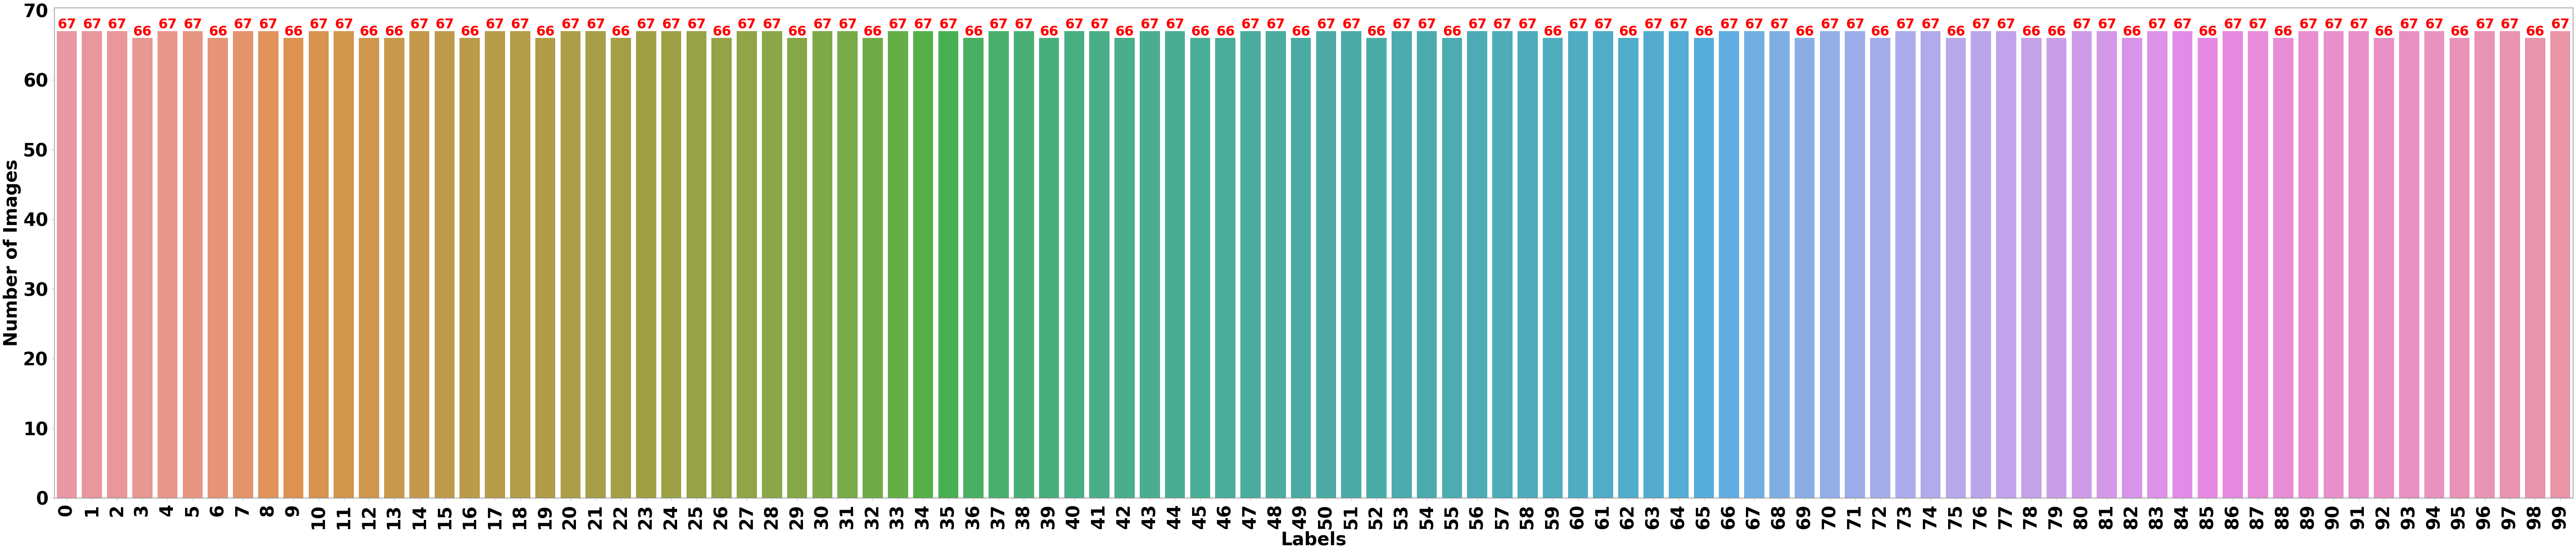

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.facecolor'] = 'white'
lbl = train_df['Label_numeric']
# print(lbl)
# print(lbl.size)
plt.figure(figsize=(100,20))
ax = sns.countplot(x= lbl, data=train_df)
ax.bar_label(ax.containers[0], weight = 'bold', fontsize = '30', color = 'red')
plt.xticks(rotation=90, fontsize = 40, weight = 'bold', color = 'black')
plt.yticks( fontsize = 40, weight = 'bold', color = 'black')
plt.xlabel("Labels", fontsize = 40, weight = 'bold', color = 'black')
plt.ylabel("Number of Images", fontsize = 40, weight = 'bold', color = 'black')

# Images Per Catergory

In [7]:
number_classes = train_df['Label'].nunique()
print("Number of classes:", number_classes)
counted = train_df.groupby(["Label"]).size()
print(counted)

Number of classes: 100
Label
0     67
1     67
2     66
3     67
4     67
      ..
95    66
96    67
97    67
98    66
99    67
Length: 100, dtype: int64


# Writing testing  Data into CSV  (Test data frame df)

In [8]:
from pathlib import Path
import os.path
test_dir = "testing"
test_path = Path(test_dir)
filepaths = list(test_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
images = pd.concat([filepaths, labels], axis=1)
test_df = pd.DataFrame(images)
test_df

,Filepath,Label
0,testing/32/1691545.jpg,32
1,testing/32/2212521.jpg,32
2,testing/32/1508910.jpg,32
3,testing/32/1260329.jpg,32
4,testing/32/0199985.jpg,32
...,...,...
3328,testing/42/0773394.jpg,42
3329,testing/42/0875337.jpg,42
3330,testing/42/0759282.jpg,42
3331,testing/42/2228007.jpg,42


In [9]:
test_df['Label'] = test_df['Label'].map(lambda x: x.lower())

In [10]:
sorted_df = test_df.sort_values(by='Label').reset_index(drop=True)
sorted_df

,Filepath,Label
0,testing/0/0789828.jpg,0
1,testing/0/1453508.jpg,0
2,testing/0/0895165.jpg,0
3,testing/0/0536515.jpg,0
4,testing/0/0747566.jpg,0
...,...,...
3328,testing/99/0973160.jpg,99
3329,testing/99/0197892.jpg,99
3330,testing/99/1176955.jpg,99
3331,testing/99/1298910.jpg,99


In [11]:
my_list = sorted_df.Label.unique()

In [12]:
my_dict = {value: index for index, value in enumerate(my_list)}

In [13]:
sorted_df['Label_numeric'] = sorted_df['Label'].map(my_dict)
sorted_df

,Filepath,Label,Label_numeric
0,testing/0/0789828.jpg,0,0
1,testing/0/1453508.jpg,0,0
2,testing/0/0895165.jpg,0,0
3,testing/0/0536515.jpg,0,0
4,testing/0/0747566.jpg,0,0
...,...,...,...
3328,testing/99/0973160.jpg,99,99
3329,testing/99/0197892.jpg,99,99
3330,testing/99/1176955.jpg,99,99
3331,testing/99/1298910.jpg,99,99


In [14]:
test_df = sorted_df[['Filepath', 'Label_numeric', 'Label']]
test_df

,Filepath,Label_numeric,Label
0,testing/0/0789828.jpg,0,0
1,testing/0/1453508.jpg,0,0
2,testing/0/0895165.jpg,0,0
3,testing/0/0536515.jpg,0,0
4,testing/0/0747566.jpg,0,0
...,...,...,...
3328,testing/99/0973160.jpg,99,99
3329,testing/99/0197892.jpg,99,99
3330,testing/99/1176955.jpg,99,99
3331,testing/99/1298910.jpg,99,99


In [15]:
label_counts = sorted_df['Label_numeric'].value_counts().sort_index().tolist()
print(label_counts)

[33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33]


In [16]:
labels = sorted_df.Label_numeric.tolist()
print(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 

Text(0, 0.5, 'Number of Images')

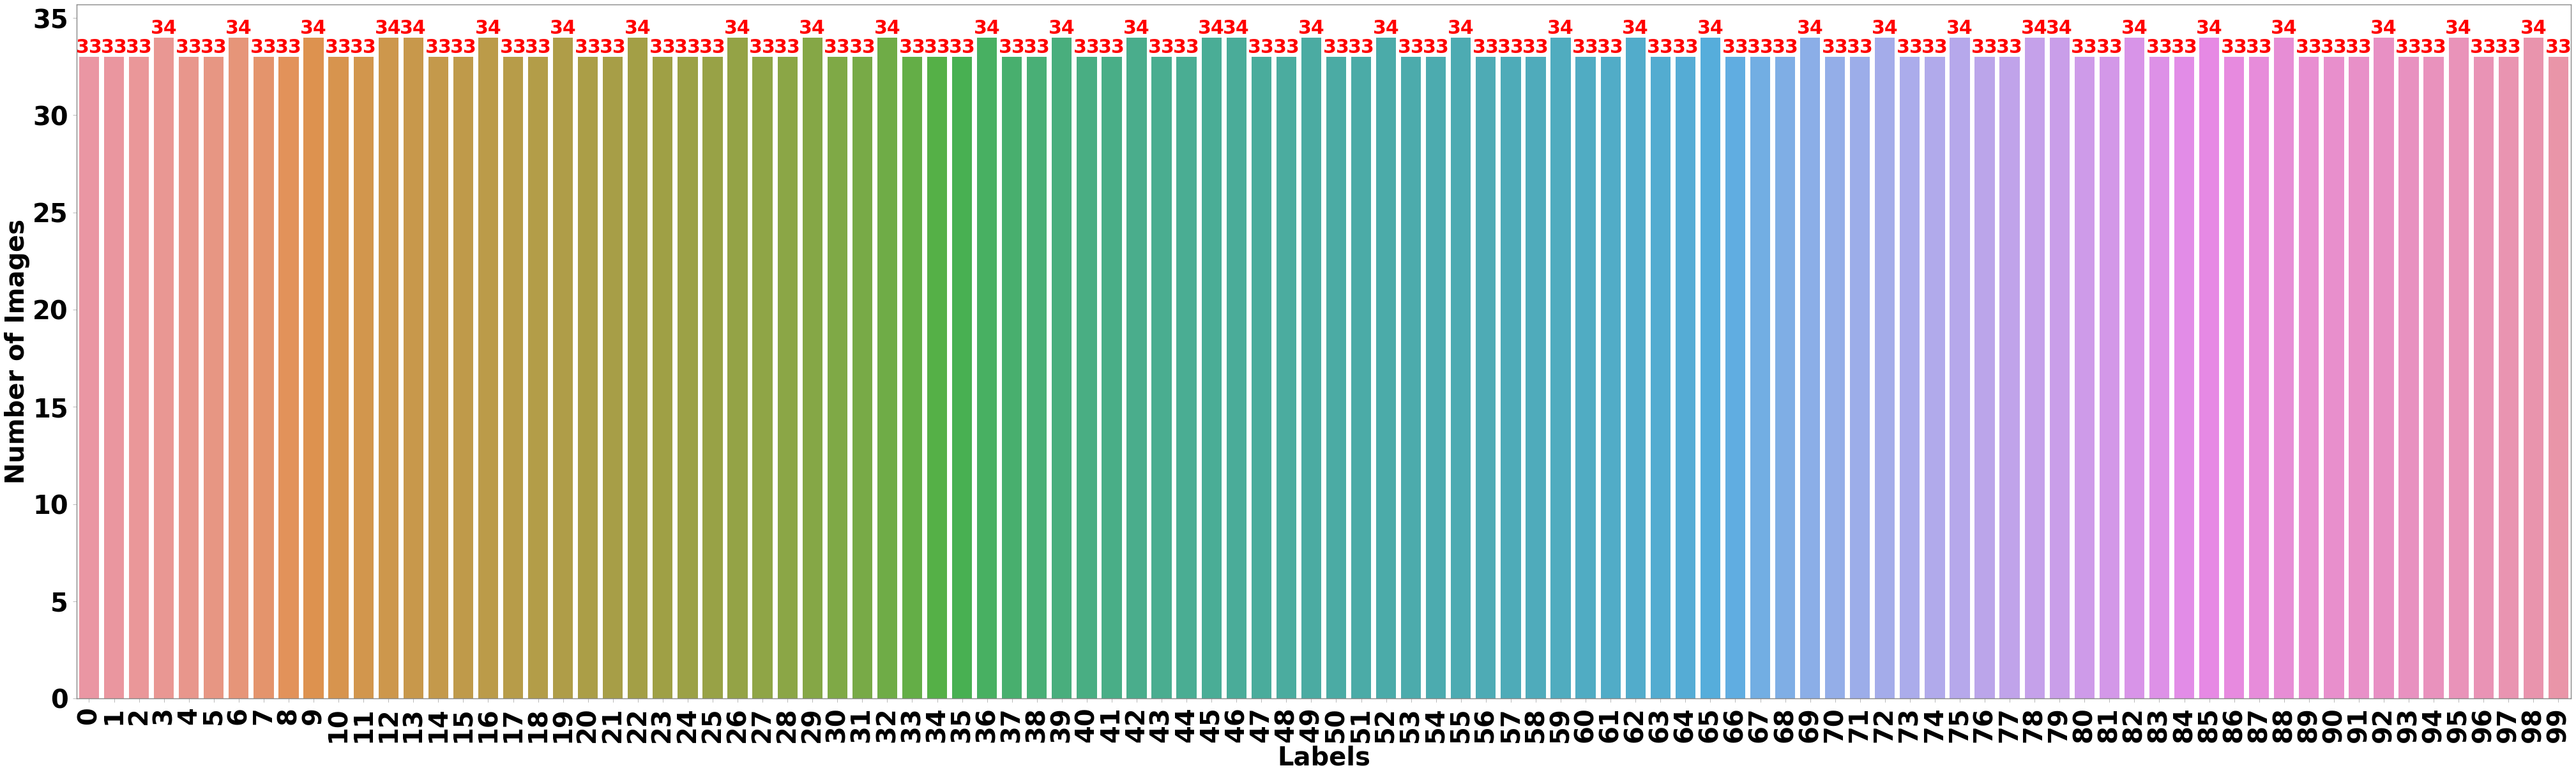

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
lbl = test_df['Label_numeric']
# print(lbl)
# print(lbl.size)
plt.figure(figsize=(70,20))
ax = sns.countplot(x= lbl, data=test_df)
ax.bar_label(ax.containers[0], weight = 'bold', fontsize = '30', color = 'red')
plt.xticks(rotation=90, fontsize = 40, weight = 'bold', color = 'black')
plt.yticks( fontsize = 40, weight = 'bold', color = 'black')
plt.xlabel("Labels", fontsize = 40, weight = 'bold', color = 'black')
plt.ylabel("Number of Images", fontsize = 40, weight = 'bold', color = 'black')

# Preparation of data for learner (Fastai learner)

In [21]:
batch_tfms = [Zoom(),Rotate(), Flip(), Brightness(), Contrast(), Saturation()]

In [22]:

# default augmentation
bs   = batch_size[architecture]
imgs = effnet_size[architecture]
resize = (imgs*4)//3
data0 = (ImageDataLoaders.from_df(train_df, valid_pct=0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

print("Image size=", imgs)
print("Batch size=", bs)
print("Architecture=", architecture)
print(resize)

Image size= 450
Batch size= 16
Architecture= efficientnet-b4
600


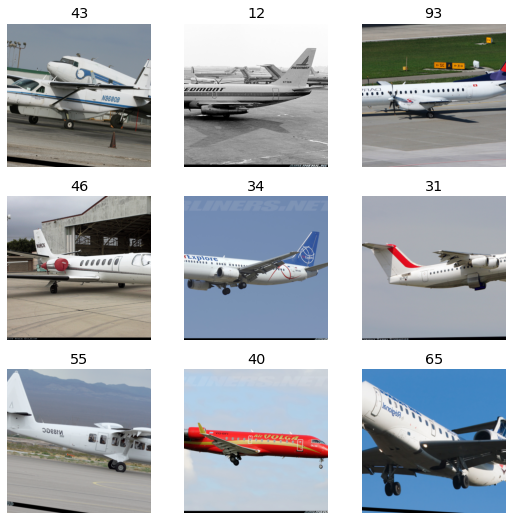

In [23]:
data0.show_batch()

In [5]:
import damped_losses as losses
loss_func = losses.DampedGCELossFlat(num_classes=num_classes,q=0.5, delta = 0.0, reduction='mean')
model = EfficientNet.from_pretrained(architecture, num_classes=num_classes)
learner_type = Learner

In [25]:
best_pth = best_pth
checkpoints = SaveModelCallback(fname=best_pth,monitor='accuracy',comp=np.greater, with_opt=True)
learn = ( learner_type(data0, model,metrics=[accuracy],loss_func=loss_func,
                        cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
print("Best pth is=", best_pth)

Best pth is= gce_aircrafts_asym_0.3_baseline


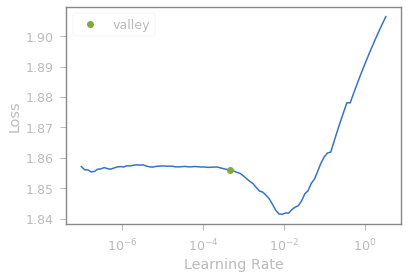

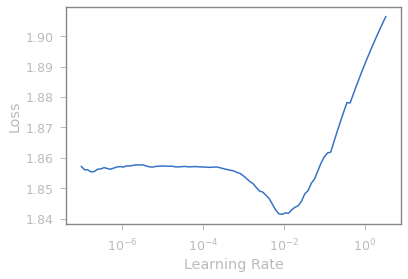

In [26]:
learn.lr_find()
learn.recorder.plot_lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.642830,1.558772,0.138035,01:49
1,1.372256,1.563619,0.142536,01:48
2,1.230123,1.249001,0.296324,01:48
3,1.098037,1.143885,0.366092,01:48
4,0.946499,1.005233,0.442611,01:48
5,0.812256,0.941775,0.466617,01:48
6,0.715818,0.880294,0.498875,01:48
7,0.561946,0.826455,0.528882,01:48
8,0.494385,0.799931,0.537134,01:48
9,0.428908,0.798715,0.540135,01:48


Better model found at epoch 0 with accuracy value: 0.13803450763225555.


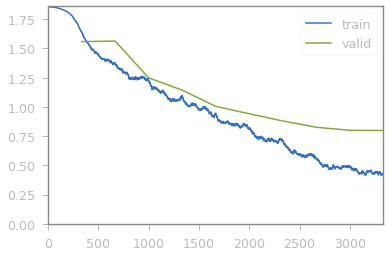

Better model found at epoch 1 with accuracy value: 0.14253562688827515.
Better model found at epoch 2 with accuracy value: 0.29632407426834106.
Better model found at epoch 3 with accuracy value: 0.3660915195941925.
Better model found at epoch 4 with accuracy value: 0.44261065125465393.
Better model found at epoch 5 with accuracy value: 0.4666166603565216.
Better model found at epoch 6 with accuracy value: 0.4988747239112854.
Better model found at epoch 7 with accuracy value: 0.5288822054862976.
Better model found at epoch 8 with accuracy value: 0.5371342897415161.
Better model found at epoch 9 with accuracy value: 0.5401350259780884.


In [27]:
low_lr = 1e-4
lr = 1e-3
learn.fit_one_cycle(10, lr_max = slice(low_lr, lr))

In [28]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,0.421240,0.799866,0.540885,01:48
1,0.407075,0.810238,0.534134,01:48
2,0.399677,0.839853,0.510128,01:49
3,0.406478,0.872684,0.501125,01:48
4,0.397074,0.876892,0.502626,01:48
5,0.442266,0.935712,0.465866,01:49
6,0.479476,0.935053,0.468117,01:48
7,0.528638,0.993084,0.447862,01:48
8,0.564686,1.022350,0.423106,01:49
9,0.583198,1.092568,0.396849,01:48


Better model found at epoch 0 with accuracy value: 0.5408852100372314.


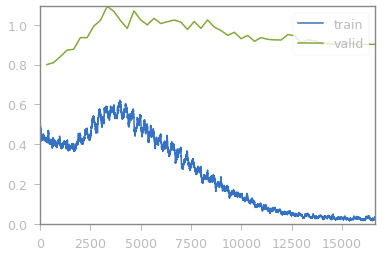

In [29]:
learn.fit_one_cycle(50, lr_max = slice(low_lr, lr))

**Loss plot of the baseline:**
    
Due to the high noise in the data, the baseline struggles both in terms of training loss as well as validation loss as the model tends to overfit easily to the noise.

In [30]:
data_test = (ImageDataLoaders.from_df(test_df, valid_pct = 0.0, splitter=None, shuffle=False, label_col=1, item_tfms=Resize(imgs)))
preds = learn.get_preds(dl=data_test)
preds
print("length of preds[1]",len(preds[1]))
acc= accuracy(preds[0], preds[1])
print(" BaselineTop-1 Accuracy:", acc)

length of preds[1] 3333
 BaselineTop-1 Accuracy: TensorBase(0.7489)


In [31]:
err = {}
acc = []
log_preds, y  = learn.tta(dl=data_test)
tta_acc = accuracy(log_preds, y)
print(tta_acc)
err[0] = (100.0, 100.0*(1.0-float(tta_acc)))
acc.append(tta_acc)

TensorBase(0.7561)


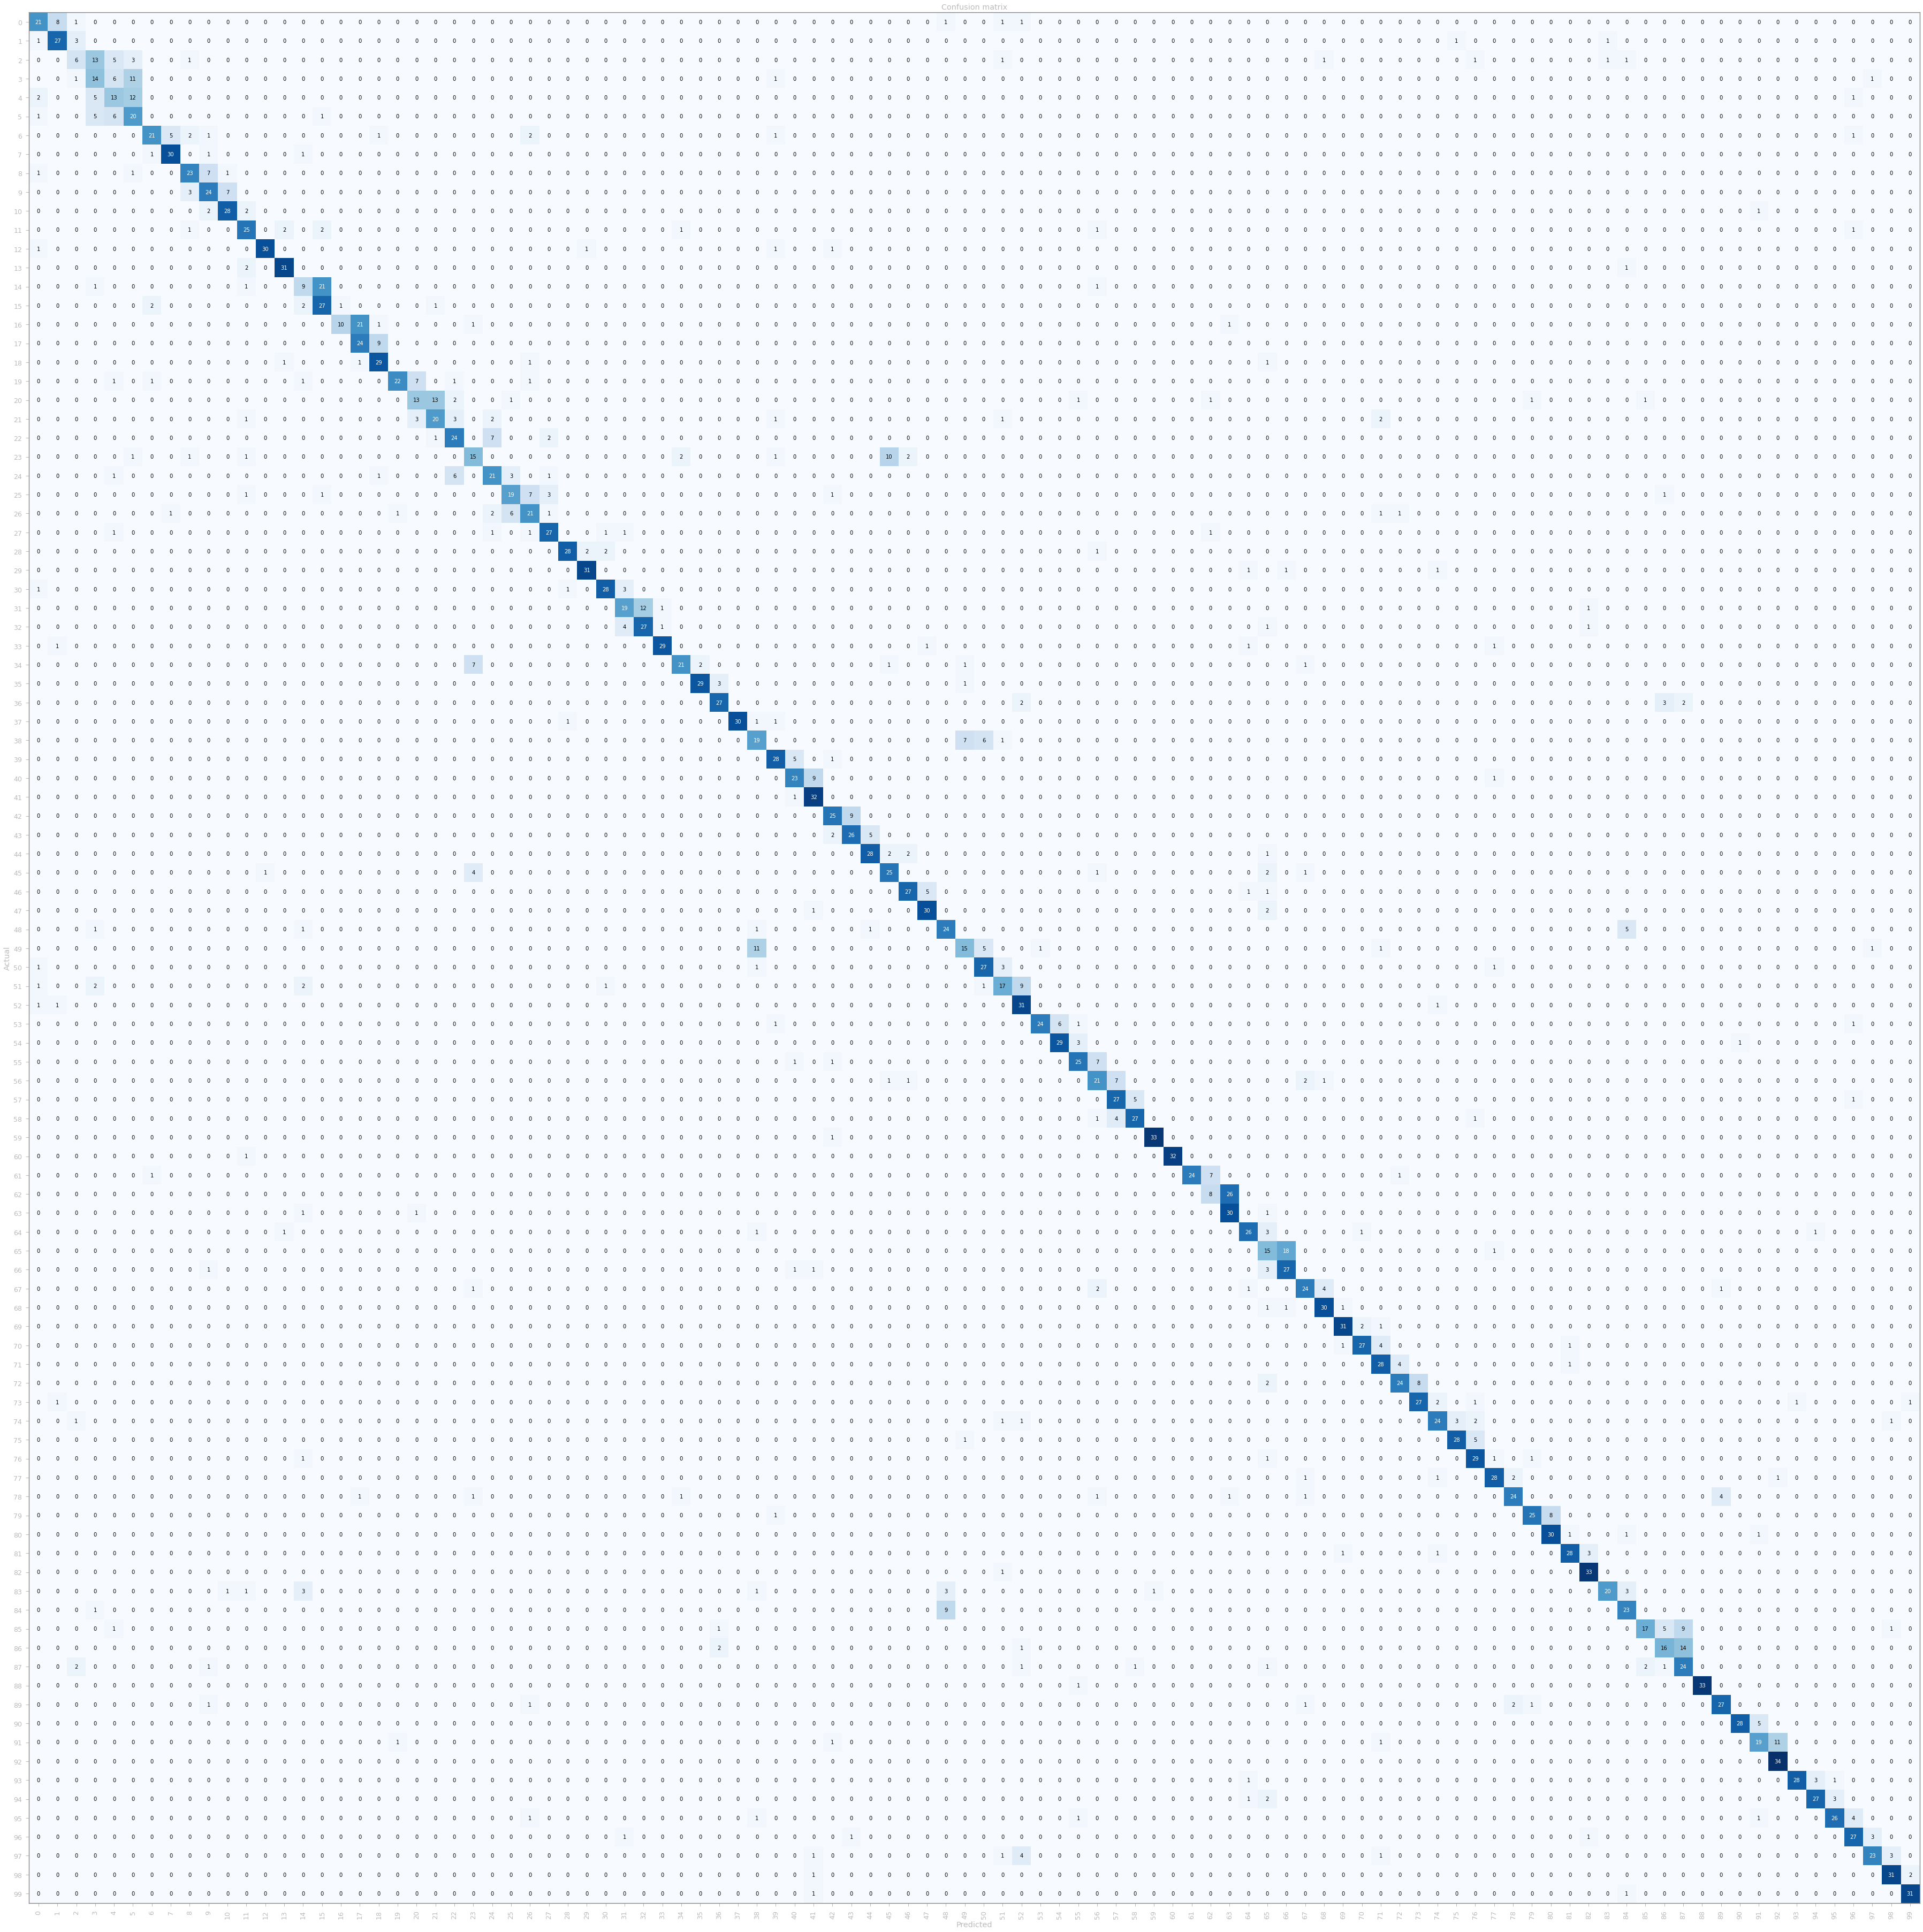

In [32]:
inter_test = ClassificationInterpretation.from_learner(learn, dl =data_test)
inter_test.plot_confusion_matrix(figsize = (50,50))

In [33]:
PATH='models/'+feature_path+'.p'
torch.save(model.state_dict(), PATH)

In [34]:
# import shutil
import os
# Specify the path of the folder where you want to create the directory
folder_path = 'models'

# Specify the name of the directory you want to create
directory_name = 'baseline'

# Combine the folder path and directory name
new_directory_path = os.path.join(folder_path, directory_name)

# Create the directory
try:
    # Create the directory
    os.makedirs(new_directory_path)
    print(f"Directory '{directory_name}' created inside '{folder_path}'.")
except FileExistsError:
    print(f"Directory '{directory_name}' already exists inside '{folder_path}'.")

# Now, here we copy the best model for baseline and past into the destination, like the folder we created inside the model directory, named "baseline"!!!!!
source = 'models/'+best_pth+'.pth'

destination = 'models/baseline/'+best_pth+'.pth'
# Copy the file from source to destination
shutil.copy(source, destination)

Directory 'baseline' already exists inside 'models'.


'models/baseline/gce_aircrafts_asym_0.3_baseline.pth'

In [35]:
drop_idxx = []
los = []
top_losses = []
k_samples = 100       # Number of samples for top losses filtering

def class_frequencies(data,class_key='Label'):
    classes = set(data[class_key])
    class_freq = {}
    max_freq = 0.5
    min_freq =100000#1000000
    for cl in classes:
        class_df = data[data[class_key]==cl]
        freq = len(class_df)
        max_freq = max(freq,max_freq)
        min_freq = min(freq,min_freq)
        class_freq[cl] = freq
        #print(f'Frequency of class {cl}: {class_freq[cl]} ')
    print(f'Max frequency is {max_freq}')
    print(f'Min frequency is {min_freq}')
    return class_freq,max_freq,min_freq
    

def russian_roulette(idx, losses, data,class_key='Label', min_prob=0.5,max_prob=0.9): #min_prob=0.5,max_prob=0.9 original values
    
    class_freq,max_freq,min_freq = class_frequencies(data,class_key)
    min_prob = float(min_freq/max_freq)*max_prob
    print(f'Min probability = {min_prob}')
    deltap = (max_prob - min_prob)/(max_freq**2)
    drop_idx = []
    for n,i in enumerate(idx.numpy()):
        l = data.iloc[i][class_key]
        prob = min_prob + (class_freq[l]-min_freq)*deltap
        r = rn.random()
        if  r < prob:
            drop_idx.append(i)
            class_freq[l] -= 1 
    return drop_idx

def data_definition(data,imgs,tfms,model,best_pth,k_samples=k_samples, min_prob=0.4, max_prob = 0.9, largest=True): # k_sample = 1000
    databunch = ( ImageDataLoaders.from_df(data, valid_pct=0.0, bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

    learn_cln = (learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func, cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
    learn_cln.load(best_pth)
    entire_training_set_csv0 = (ImageDataLoaders.from_df(data, valid_pct = 0.0, splitter=None, shuffle=False, label_col=1, item_tfms=Resize(imgs)))
    interp = ClassificationInterpretation.from_learner(learn_cln, dl = entire_training_set_csv0)
    losses = None
    idx = None
    if hybrid:
        l_big,idx_big = interp.top_losses(k_samples//2,largest=True)
        l_sm,idx_sm = interp.top_losses(k_samples//2,largest=False)
        losses = torch.cat((l_big,l_sm),0)
        idx = torch.cat((idx_big,idx_sm),0)
    else:
        losses,idx = interp.top_losses(k_samples,largest=largest)
    drop_idx = russian_roulette(idx,losses,data,min_prob = min_prob, max_prob = max_prob)
    data_filtered = data.drop(data.index[drop_idx])
    print(f'Dropped {len(drop_idx)} top losses')
    return data_filtered

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 43 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6624


epoch,train_loss,valid_loss,accuracy,time
0,0.495660,0.405239,0.778701,01:50


Better model found at epoch 0 with accuracy value: 0.7787008881568909.


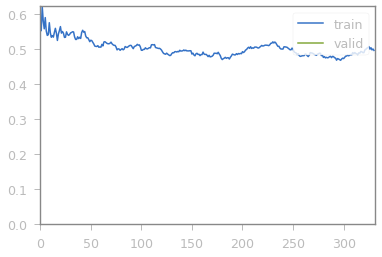

************Round:  0
TTA Accuracy:0.7569757103919983
cycle 0 Error Rate is [{0: (0.6449677516124241, 24.30242896080017)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 62
Min probability = 0.8328358208955224
Dropped 41 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6583


epoch,train_loss,valid_loss,accuracy,time
0,0.482274,0.402251,0.771277,01:48


Better model found at epoch 0 with accuracy value: 0.771276593208313.


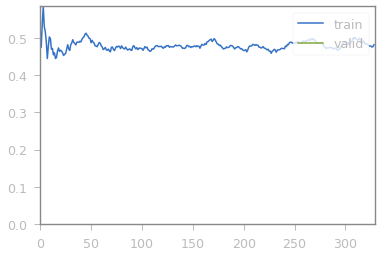

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 61
Min probability = 0.8194029850746268
Dropped 44 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6539


epoch,train_loss,valid_loss,accuracy,time
0,0.479685,0.367171,0.791890,01:47


Better model found at epoch 0 with accuracy value: 0.7918898463249207.


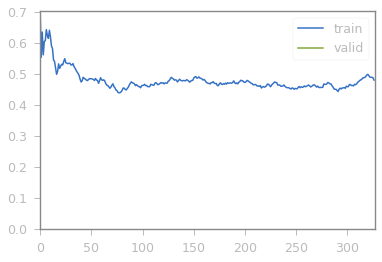

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 39 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6500


epoch,train_loss,valid_loss,accuracy,time
0,0.459719,0.393754,0.773846,01:46


Better model found at epoch 0 with accuracy value: 0.7738461494445801.


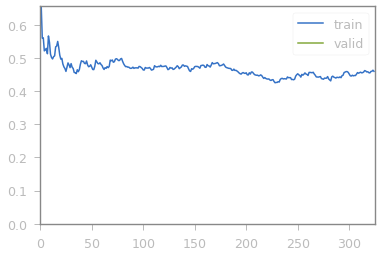

************Round:  3
TTA Accuracy:0.7650765180587769
cycle 0 Error Rate is [{0: (0.6449677516124241, 24.30242896080017), 3: (2.5048747562621876, 23.492348194122314)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 58
Min probability = 0.7791044776119402
Dropped 38 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6462


epoch,train_loss,valid_loss,accuracy,time
0,0.460497,0.367540,0.789474,01:46


Better model found at epoch 0 with accuracy value: 0.7894737124443054.


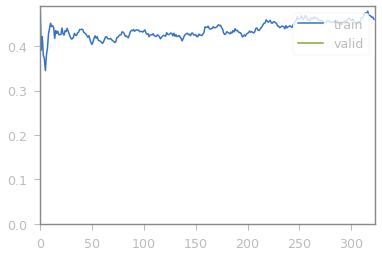

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 56
Min probability = 0.7522388059701492
Dropped 41 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6421


epoch,train_loss,valid_loss,accuracy,time
0,0.426769,0.367600,0.788941,01:45


Better model found at epoch 0 with accuracy value: 0.7889407873153687.


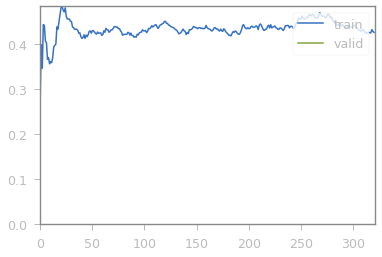

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 56
Min probability = 0.7522388059701492
Dropped 38 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6383


epoch,train_loss,valid_loss,accuracy,time
0,0.428477,0.353006,0.807210,01:44


Better model found at epoch 0 with accuracy value: 0.8072100281715393.


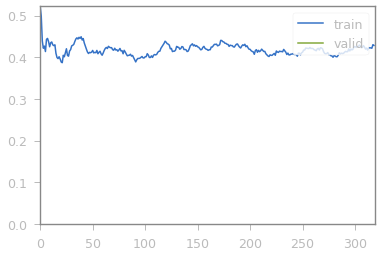

************Round:  6
TTA Accuracy:0.7617761492729187
cycle 0 Error Rate is [{0: (0.6449677516124241, 24.30242896080017), 3: (2.5048747562621876, 23.492348194122314), 6: (4.259787010649463, 23.82238507270813)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 56
Min probability = 0.7522388059701492
Dropped 40 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6343


epoch,train_loss,valid_loss,accuracy,time
0,0.434667,0.354367,0.791798,01:43


Better model found at epoch 0 with accuracy value: 0.7917981147766113.


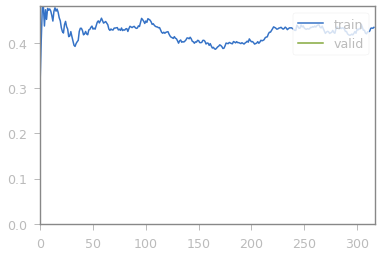

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 56
Min probability = 0.7522388059701492
Dropped 40 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6303


epoch,train_loss,valid_loss,accuracy,time
0,0.427497,0.333096,0.811905,01:43


Better model found at epoch 0 with accuracy value: 0.811904788017273.


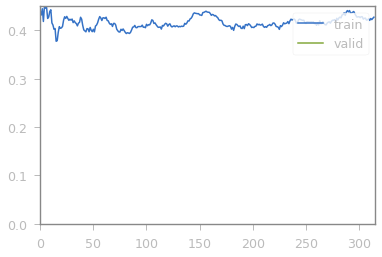

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 56
Min probability = 0.7522388059701492
Dropped 37 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6266


epoch,train_loss,valid_loss,accuracy,time
0,0.378896,0.353010,0.799681,01:42


Better model found at epoch 0 with accuracy value: 0.799680769443512.


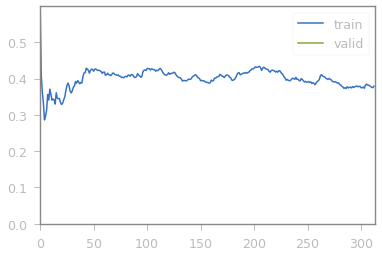

************Round:  9
TTA Accuracy:0.756675660610199
cycle 0 Error Rate is [{0: (0.6449677516124241, 24.30242896080017), 3: (2.5048747562621876, 23.492348194122314), 6: (4.259787010649463, 23.82238507270813), 9: (6.014699265036749, 24.332433938980103)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 55
Min probability = 0.7388059701492538
Dropped 37 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
6229


epoch,train_loss,valid_loss,accuracy,time
0,0.419907,0.341325,0.814458,01:44


Better model found at epoch 0 with accuracy value: 0.8144578337669373.


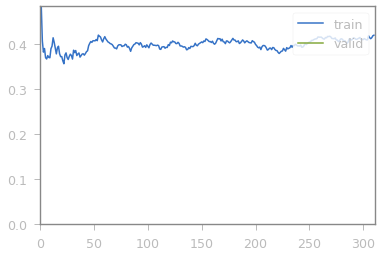

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 55
Min probability = 0.7388059701492538
Dropped 40 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
6189


epoch,train_loss,valid_loss,accuracy,time
0,0.398286,0.303009,0.835085,01:41


Better model found at epoch 0 with accuracy value: 0.835084855556488.


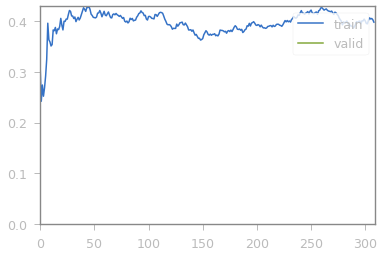

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 37 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
6152


epoch,train_loss,valid_loss,accuracy,time
0,0.379009,0.321192,0.822764,01:43


Better model found at epoch 0 with accuracy value: 0.8227642178535461.


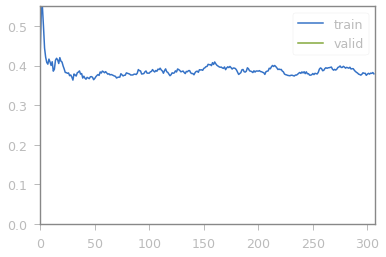

************Round:  12
TTA Accuracy:0.7602760195732117
cycle 0 Error Rate is [{0: (0.6449677516124241, 24.30242896080017), 3: (2.5048747562621876, 23.492348194122314), 6: (4.259787010649463, 23.82238507270813), 9: (6.014699265036749, 24.332433938980103), 12: (7.724613769311539, 23.972398042678833)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 53
Min probability = 0.7119402985074627
Dropped 33 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
6119


epoch,train_loss,valid_loss,accuracy,time
0,0.385579,0.301563,0.840556,01:40


Better model found at epoch 0 with accuracy value: 0.8405560255050659.


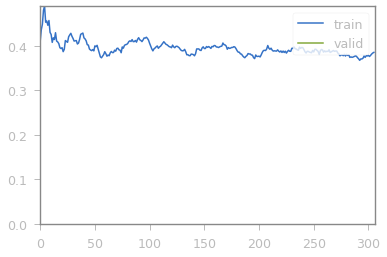

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 53
Min probability = 0.7119402985074627
Dropped 36 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
6083


epoch,train_loss,valid_loss,accuracy,time
0,0.384225,0.289994,0.844572,01:39


Better model found at epoch 0 with accuracy value: 0.8445723652839661.


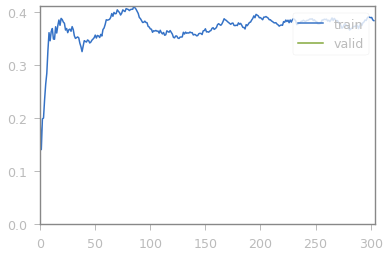

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 42 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6625


epoch,train_loss,valid_loss,accuracy,time
0,0.388000,0.300638,0.843019,01:48


Better model found at epoch 0 with accuracy value: 0.8430188894271851.


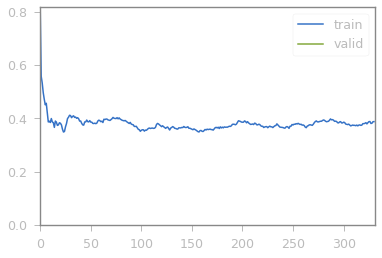

************Round:  0
TTA Accuracy:0.7554755210876465
cycle 1 Error Rate is [{0: (0.6449677516124241, 24.30242896080017), 3: (2.5048747562621876, 23.492348194122314), 6: (4.259787010649463, 23.82238507270813), 9: (6.014699265036749, 24.332433938980103), 12: (7.724613769311539, 23.972398042678833), 15: (0.6299685015749179, 24.45244789123535)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 63
Min probability = 0.8462686567164179
Dropped 45 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6580


epoch,train_loss,valid_loss,accuracy,time
0,0.362927,0.280801,0.852584,01:47


Better model found at epoch 0 with accuracy value: 0.8525835871696472.


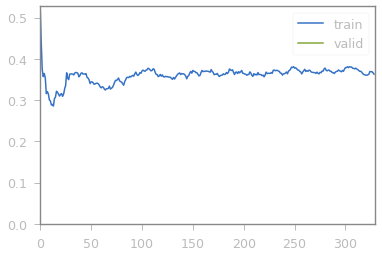

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 61
Min probability = 0.8194029850746268
Dropped 38 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6542


epoch,train_loss,valid_loss,accuracy,time
0,0.348469,0.308154,0.837156,01:47


Better model found at epoch 0 with accuracy value: 0.8371559381484985.


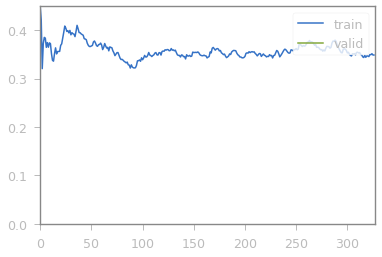

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 38 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6504


epoch,train_loss,valid_loss,accuracy,time
0,0.369399,0.246060,0.866923,01:47


Better model found at epoch 0 with accuracy value: 0.8669230937957764.


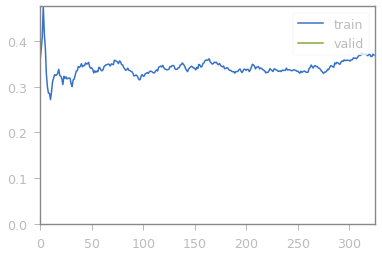

************Round:  3
TTA Accuracy:0.7488749027252197
cycle 1 Error Rate is [{0: (0.6449677516124241, 24.30242896080017), 3: (2.5048747562621876, 23.492348194122314), 6: (4.259787010649463, 23.82238507270813), 9: (6.014699265036749, 24.332433938980103), 12: (7.724613769311539, 23.972398042678833), 15: (0.6299685015749179, 24.45244789123535), 18: (2.444877756112196, 25.112509727478027)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 38 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6466


epoch,train_loss,valid_loss,accuracy,time
0,0.377793,0.248780,0.865429,01:46


Better model found at epoch 0 with accuracy value: 0.8654292225837708.


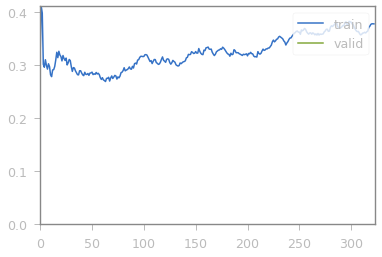

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 42 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6424


epoch,train_loss,valid_loss,accuracy,time
0,0.347714,0.236300,0.867601,01:45


Better model found at epoch 0 with accuracy value: 0.8676012754440308.


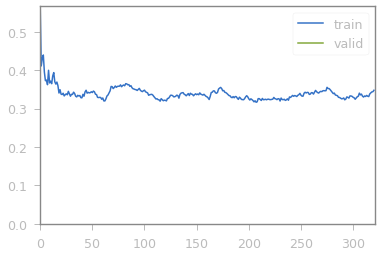

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 39 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6385


epoch,train_loss,valid_loss,accuracy,time
0,0.333548,0.251797,0.859828,01:44


Better model found at epoch 0 with accuracy value: 0.8598276972770691.


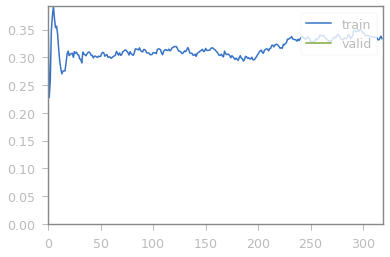

************Round:  6
TTA Accuracy:0.7368736863136292
cycle 1 Error Rate is [{0: (0.6449677516124241, 24.30242896080017), 3: (2.5048747562621876, 23.492348194122314), 6: (4.259787010649463, 23.82238507270813), 9: (6.014699265036749, 24.332433938980103), 12: (7.724613769311539, 23.972398042678833), 15: (0.6299685015749179, 24.45244789123535), 18: (2.444877756112196, 25.112509727478027), 21: (4.229788510574473, 26.312631368637085)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 38 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6347


epoch,train_loss,valid_loss,accuracy,time
0,0.311502,0.223830,0.874704,01:43


Better model found at epoch 0 with accuracy value: 0.8747044801712036.


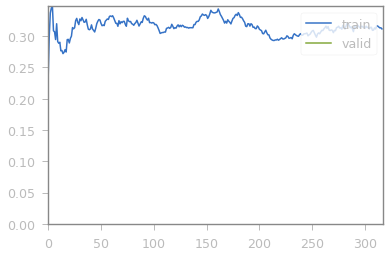

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 42 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6305


epoch,train_loss,valid_loss,accuracy,time
0,0.303794,0.227946,0.870737,01:43


Better model found at epoch 0 with accuracy value: 0.8707374930381775.


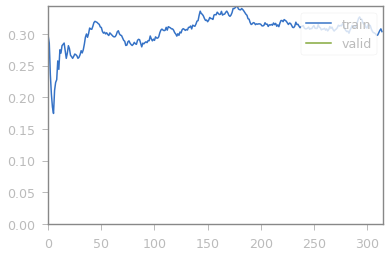

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 56
Min probability = 0.7522388059701492
Dropped 40 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6265


epoch,train_loss,valid_loss,accuracy,time
0,0.314112,0.204077,0.888268,01:43


Better model found at epoch 0 with accuracy value: 0.8882681727409363.


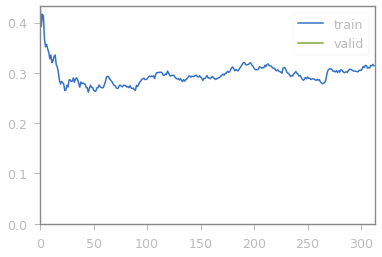

************Round:  9
TTA Accuracy:0.7311730980873108
cycle 1 Error Rate is [{0: (0.6449677516124241, 24.30242896080017), 3: (2.5048747562621876, 23.492348194122314), 6: (4.259787010649463, 23.82238507270813), 9: (6.014699265036749, 24.332433938980103), 12: (7.724613769311539, 23.972398042678833), 15: (0.6299685015749179, 24.45244789123535), 18: (2.444877756112196, 25.112509727478027), 21: (4.229788510574473, 26.312631368637085), 24: (6.029698515074244, 26.88269019126892)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 55
Min probability = 0.7388059701492538
Dropped 39 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
6226


epoch,train_loss,valid_loss,accuracy,time
0,0.330984,0.186106,0.893976,01:41


Better model found at epoch 0 with accuracy value: 0.8939759135246277.


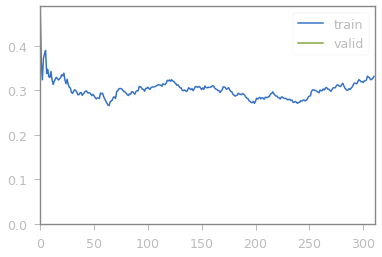

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 55
Min probability = 0.7388059701492538
Dropped 34 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
6192


epoch,train_loss,valid_loss,accuracy,time
0,0.291098,0.201280,0.891761,01:43


Better model found at epoch 0 with accuracy value: 0.8917608857154846.


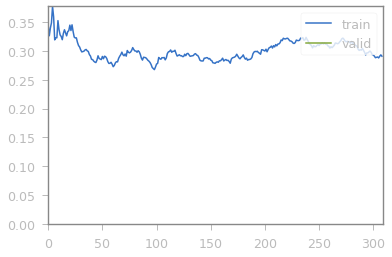

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 53
Min probability = 0.7119402985074627
Dropped 37 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
6155


epoch,train_loss,valid_loss,accuracy,time
0,0.280037,0.203908,0.887896,01:43


Better model found at epoch 0 with accuracy value: 0.8878960013389587.


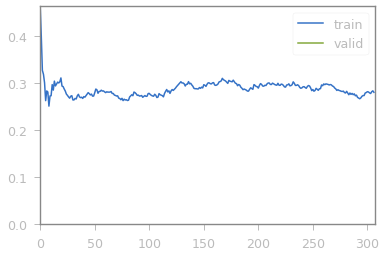

************Round:  12
TTA Accuracy:0.737473726272583
cycle 1 Error Rate is [{0: (0.6449677516124241, 24.30242896080017), 3: (2.5048747562621876, 23.492348194122314), 6: (4.259787010649463, 23.82238507270813), 9: (6.014699265036749, 24.332433938980103), 12: (7.724613769311539, 23.972398042678833), 15: (0.6299685015749179, 24.45244789123535), 18: (2.444877756112196, 25.112509727478027), 21: (4.229788510574473, 26.312631368637085), 24: (6.029698515074244, 26.88269019126892), 27: (7.679616019199043, 26.2526273727417)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 51
Min probability = 0.6850746268656717
Dropped 35 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
6120


epoch,train_loss,valid_loss,accuracy,time
0,0.273663,0.174618,0.911765,01:40


Better model found at epoch 0 with accuracy value: 0.9117646813392639.


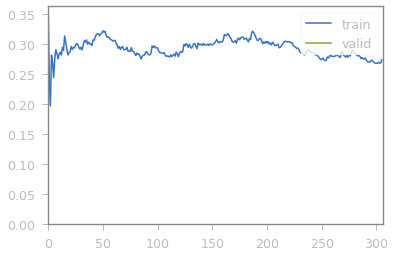

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 50
Min probability = 0.6716417910447762
Dropped 32 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
6088


epoch,train_loss,valid_loss,accuracy,time
0,0.278974,0.190970,0.898932,01:41


Better model found at epoch 0 with accuracy value: 0.8989318013191223.


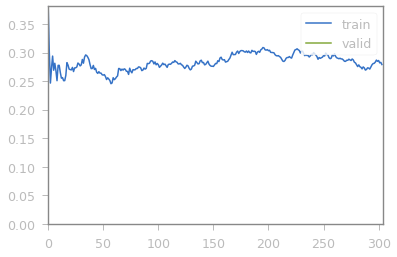

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 42 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6625


epoch,train_loss,valid_loss,accuracy,time
0,0.284588,0.188657,0.898868,01:48


Better model found at epoch 0 with accuracy value: 0.8988679051399231.


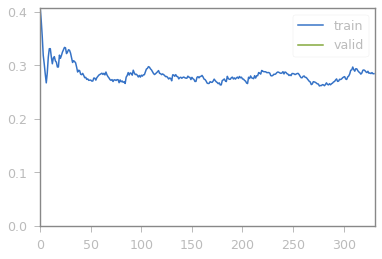

************Round:  0
TTA Accuracy:0.732073187828064
cycle 2 Error Rate is [{0: (0.6449677516124241, 24.30242896080017), 3: (2.5048747562621876, 23.492348194122314), 6: (4.259787010649463, 23.82238507270813), 9: (6.014699265036749, 24.332433938980103), 12: (7.724613769311539, 23.972398042678833), 15: (0.6299685015749179, 24.45244789123535), 18: (2.444877756112196, 25.112509727478027), 21: (4.229788510574473, 26.312631368637085), 24: (6.029698515074244, 26.88269019126892), 27: (7.679616019199043, 26.2526273727417), 30: (0.6299685015749179, 26.792681217193604)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 64
Min probability = 0.8597014925373134
Dropped 43 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6582


epoch,train_loss,valid_loss,accuracy,time
0,0.277003,0.190380,0.893617,01:47


Better model found at epoch 0 with accuracy value: 0.8936170339584351.


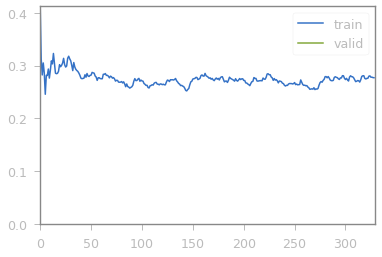

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 63
Min probability = 0.8462686567164179
Dropped 42 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6540


epoch,train_loss,valid_loss,accuracy,time
0,0.253213,0.172159,0.907492,01:47


Better model found at epoch 0 with accuracy value: 0.9074923396110535.


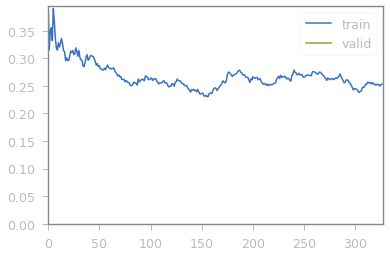

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 62
Min probability = 0.8328358208955224
Dropped 38 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6502


epoch,train_loss,valid_loss,accuracy,time
0,0.260280,0.168907,0.905385,01:46


Better model found at epoch 0 with accuracy value: 0.9053846001625061.


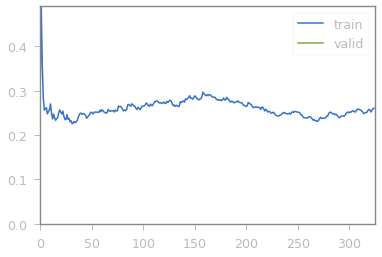

************Round:  3
TTA Accuracy:0.7275727391242981
cycle 2 Error Rate is [{0: (0.6449677516124241, 24.30242896080017), 3: (2.5048747562621876, 23.492348194122314), 6: (4.259787010649463, 23.82238507270813), 9: (6.014699265036749, 24.332433938980103), 12: (7.724613769311539, 23.972398042678833), 15: (0.6299685015749179, 24.45244789123535), 18: (2.444877756112196, 25.112509727478027), 21: (4.229788510574473, 26.312631368637085), 24: (6.029698515074244, 26.88269019126892), 27: (7.679616019199043, 26.2526273727417), 30: (0.6299685015749179, 26.792681217193604), 33: (2.474876256187186, 27.24272608757019)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 61
Min probability = 0.8194029850746268
Dropped 43 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6459


epoch,train_loss,valid_loss,accuracy,time
0,0.241827,0.163953,0.908598,01:45


Better model found at epoch 0 with accuracy value: 0.908598005771637.


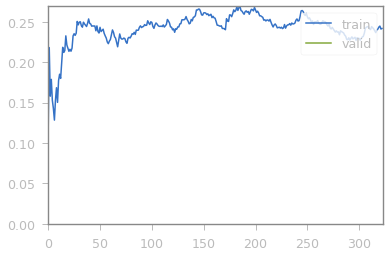

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 60
Min probability = 0.8059701492537313
Dropped 37 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6422


epoch,train_loss,valid_loss,accuracy,time
0,0.236909,0.160405,0.910436,01:45


Better model found at epoch 0 with accuracy value: 0.9104361534118652.


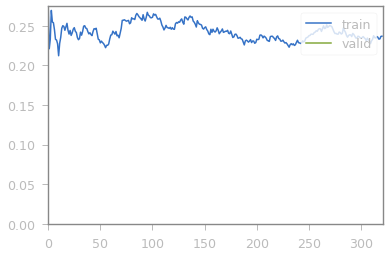

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 41 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6381


epoch,train_loss,valid_loss,accuracy,time
0,0.258523,0.144382,0.921630,01:44


Better model found at epoch 0 with accuracy value: 0.9216300845146179.


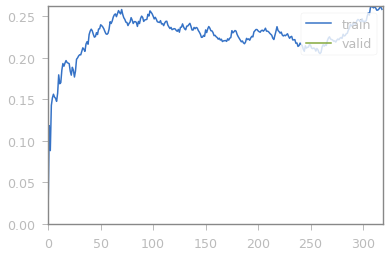

************Round:  6
TTA Accuracy:0.7227723002433777
cycle 2 Error Rate is [{0: (0.6449677516124241, 24.30242896080017), 3: (2.5048747562621876, 23.492348194122314), 6: (4.259787010649463, 23.82238507270813), 9: (6.014699265036749, 24.332433938980103), 12: (7.724613769311539, 23.972398042678833), 15: (0.6299685015749179, 24.45244789123535), 18: (2.444877756112196, 25.112509727478027), 21: (4.229788510574473, 26.312631368637085), 24: (6.029698515074244, 26.88269019126892), 27: (7.679616019199043, 26.2526273727417), 30: (0.6299685015749179, 26.792681217193604), 33: (2.474876256187186, 27.24272608757019), 36: (4.289785510724464, 27.72276997566223)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 36 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6345


epoch,train_loss,valid_loss,accuracy,time
0,0.221087,0.170317,0.908589,01:44


Better model found at epoch 0 with accuracy value: 0.9085894227027893.


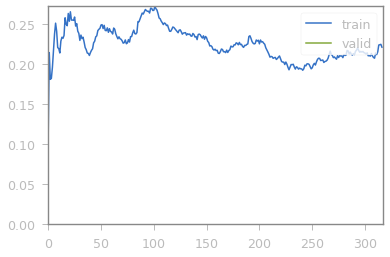

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 35 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6310


epoch,train_loss,valid_loss,accuracy,time
0,0.223309,0.140560,0.926307,01:43


Better model found at epoch 0 with accuracy value: 0.9263074398040771.


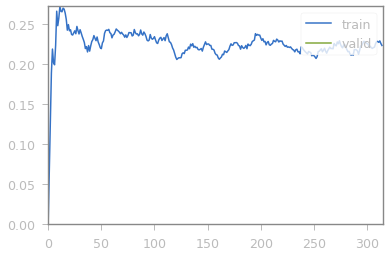

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 40 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6270


epoch,train_loss,valid_loss,accuracy,time
0,0.213576,0.137956,0.926635,01:43


Better model found at epoch 0 with accuracy value: 0.9266347885131836.


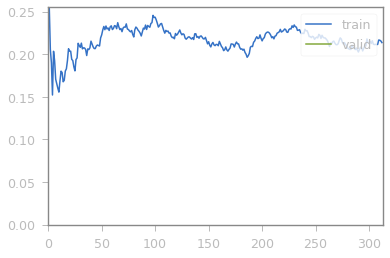

************Round:  9
TTA Accuracy:0.7266726493835449
cycle 2 Error Rate is [{0: (0.6449677516124241, 24.30242896080017), 3: (2.5048747562621876, 23.492348194122314), 6: (4.259787010649463, 23.82238507270813), 9: (6.014699265036749, 24.332433938980103), 12: (7.724613769311539, 23.972398042678833), 15: (0.6299685015749179, 24.45244789123535), 18: (2.444877756112196, 25.112509727478027), 21: (4.229788510574473, 26.312631368637085), 24: (6.029698515074244, 26.88269019126892), 27: (7.679616019199043, 26.2526273727417), 30: (0.6299685015749179, 26.792681217193604), 33: (2.474876256187186, 27.24272608757019), 36: (4.289785510724464, 27.72276997566223), 39: (5.954702264886757, 27.332735061645508)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 40 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
6230


epoch,train_loss,valid_loss,accuracy,time
0,0.191077,0.132529,0.932584,01:42


Better model found at epoch 0 with accuracy value: 0.932584285736084.


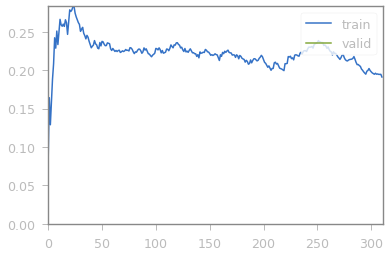

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 32 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
6198


epoch,train_loss,valid_loss,accuracy,time
0,0.229994,0.126748,0.931396,01:41


Better model found at epoch 0 with accuracy value: 0.9313963055610657.


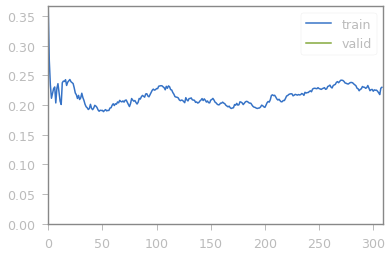

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 34 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
6164


epoch,train_loss,valid_loss,accuracy,time
0,0.199674,0.133357,0.931818,01:41


Better model found at epoch 0 with accuracy value: 0.9318181872367859.


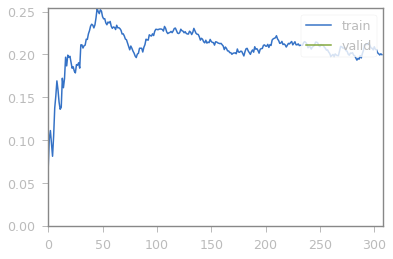

************Round:  12
TTA Accuracy:0.7188718914985657
cycle 2 Error Rate is [{0: (0.6449677516124241, 24.30242896080017), 3: (2.5048747562621876, 23.492348194122314), 6: (4.259787010649463, 23.82238507270813), 9: (6.014699265036749, 24.332433938980103), 12: (7.724613769311539, 23.972398042678833), 15: (0.6299685015749179, 24.45244789123535), 18: (2.444877756112196, 25.112509727478027), 21: (4.229788510574473, 26.312631368637085), 24: (6.029698515074244, 26.88269019126892), 27: (7.679616019199043, 26.2526273727417), 30: (0.6299685015749179, 26.792681217193604), 33: (2.474876256187186, 27.24272608757019), 36: (4.289785510724464, 27.72276997566223), 39: (5.954702264886757, 27.332735061645508), 42: (7.544622768861553, 28.112810850143433)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 42 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
6122


epoch,train_loss,valid_loss,accuracy,time
0,0.203952,0.113477,0.942810,01:41


Better model found at epoch 0 with accuracy value: 0.9428104758262634.


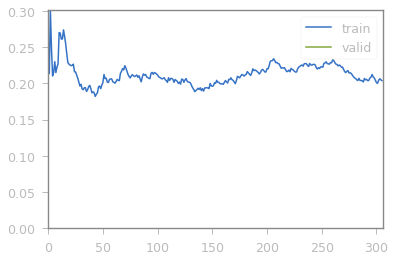

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 66
Min frequency is 56
Min probability = 0.7636363636363637
Dropped 36 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
6086


epoch,train_loss,valid_loss,accuracy,time
0,0.200700,0.145925,0.924404,01:39


Better model found at epoch 0 with accuracy value: 0.9244042634963989.


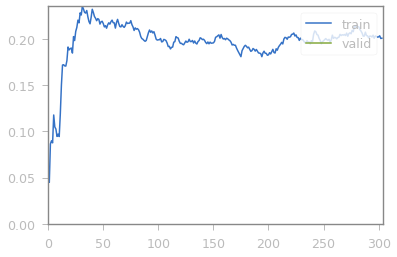

In [36]:

drop_idxx = []
los = []
top_losses = []
n_training_series = 15  # orginally it is 15, but for testing purpose we are using with 1 to check the scheme with custom function.
min_epochs = 1
min_prob=0.5
max_prob=0.9
delta_epochs_per_serie =  0
min_lr = 1e-4
kappa_lr = 1 
k_samples = 0
data_per_serie = {}
data_per_serie[0] = train_df
largest = True
from_scratch = False
hybrid = False
cleaning_cycles = 3 
delta_max = 0.25
accs = []
deltas = []
for c in range(cleaning_cycles):
    for n in range(n_training_series):
        delta =  delta_max * math.sin( math.pi * float(n+1)/(n_training_series) )
        loss_func = losses.DampedGCELossFlat(num_classes=num_classes,q=0.5, delta = delta, reduction='mean')
        
        print(f'+++++ Training serie: inverse pyramid {n} ++++++++')
        epochs_per_serie = min_epochs + n * delta_epochs_per_serie
        lr = min_lr * kappa_lr * (n_training_series - n)
        data_per_serie[n+1] = data_definition(data_per_serie[n],imgs,batch_tfms,model,best_pth,k_samples=k_samples, 
                                              min_prob = min_prob, max_prob=max_prob, largest = largest)
        print("************Round: ",n)
        print("************data per serie:******************")
        print("************length of data per serie:******************")
        print(len(data_per_serie[n+1]))
        
        databunch = ( ImageDataLoaders.from_df(data_per_serie[n+1], valid_pct = 0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

        learn =(learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func,
                            cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
        learn.unfreeze() 
        learn.load(best_pth)
        learn.fit_one_cycle(epochs_per_serie, lr_max=slice(1e-6, 5e-5))
        if n%3== 0:
            log_preds, y = learn.tta(dl=data_test)
            print("************Round: ",n)
            tta_acc = accuracy(log_preds, y)
            print(f'TTA Accuracy:{tta_acc}')
            accs.append(tta_acc)
            deltas.append(delta)
            err[c*n_training_series + n] = ( 100.0 *float(1.0 - len(data_per_serie[n+1])/len(data_per_serie[0])) ,  100.0 * (1.0 - float(tta_acc)))
            print(f'cycle {c} Error Rate is [{err}]')
            PATH='models/'+damp_1_features+'_'+str(c)+"_"+str(n)+".p"
            torch.save(model.state_dict(), PATH)
            csv = data_per_serie[n+1].to_csv('CSVz/'+damp_1_csvs+'_'+str(c)+"_"+str(n)+".csv", index = False)     
    

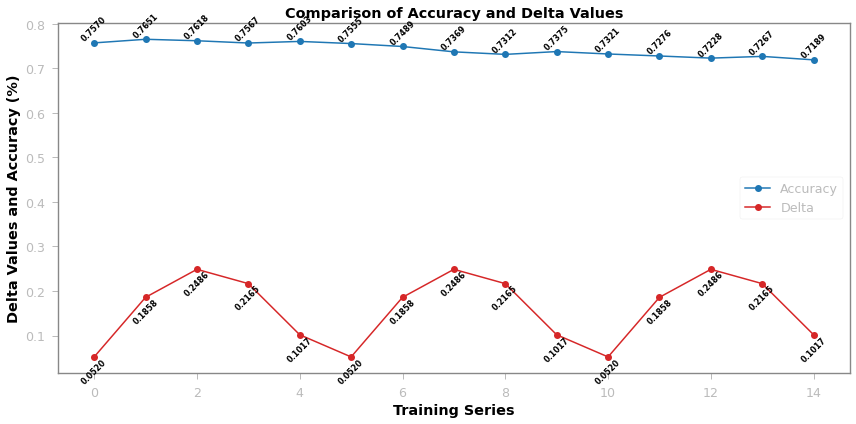

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(accs, label='Accuracy', color='tab:blue', marker='o')
plt.plot(deltas, label='Delta', color='tab:red', marker='o')

# Annotating each point with its value in black and with bold labels
for i, (acc, delta) in enumerate(zip(accs, deltas)):
    plt.text(i, acc, f"{acc:.4f}", ha='center', va='bottom', fontsize=8, rotation=45, color='black', fontweight='bold')
    plt.text(i, delta, f"{delta:.4f}", ha='center', va='top', fontsize=8, rotation=45, color='black', fontweight='bold')

plt.title('Comparison of Accuracy and Delta Values', fontweight='bold', color = 'Black')
plt.xlabel('Training Series', fontweight='bold', color = 'black')
plt.ylabel('Delta Values and Accuracy (%)', fontweight='bold', color = 'Black')
plt.legend()
plt.grid(False)
plt.tight_layout()  # Adjust layout to prevent clipping of annotations
plt.show()


+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 44 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6623


epoch,train_loss,valid_loss,accuracy,time
0,0.222724,0.125572,0.932779,01:48


Better model found at epoch 0 with accuracy value: 0.9327794313430786.


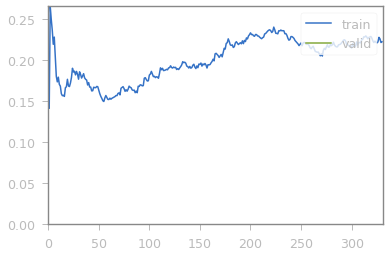

************Round:  0
TTA Accuracy:0.7080708146095276
cycle 0 Error Rate is [{0: (0.6599670016499193, 29.19291853904724)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 63
Min probability = 0.8462686567164179
Dropped 43 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6580


epoch,train_loss,valid_loss,accuracy,time
0,0.177316,0.119772,0.937690,01:48


Better model found at epoch 0 with accuracy value: 0.9376899600028992.


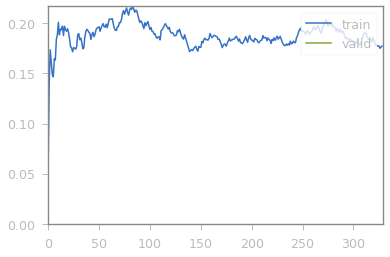

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 63
Min probability = 0.8462686567164179
Dropped 46 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6534


epoch,train_loss,valid_loss,accuracy,time
0,0.193969,0.124481,0.932619,01:49


Better model found at epoch 0 with accuracy value: 0.9326186776161194.


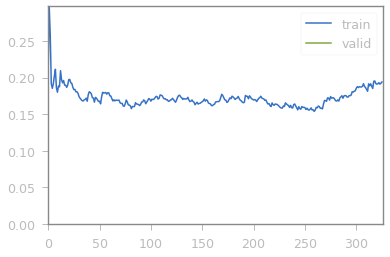

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 62
Min probability = 0.8328358208955224
Dropped 43 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6491


epoch,train_loss,valid_loss,accuracy,time
0,0.174797,0.108518,0.942219,01:46


Better model found at epoch 0 with accuracy value: 0.9422187805175781.


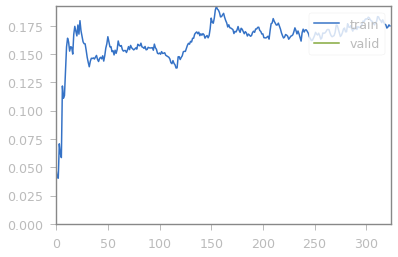

************Round:  3
TTA Accuracy:0.7050704956054688
cycle 0 Error Rate is [{0: (0.6599670016499193, 29.19291853904724), 3: (2.639868006599666, 29.492950439453125)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 60
Min probability = 0.8059701492537313
Dropped 44 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6447


epoch,train_loss,valid_loss,accuracy,time
0,0.169224,0.093686,0.948798,01:45


Better model found at epoch 0 with accuracy value: 0.9487975239753723.


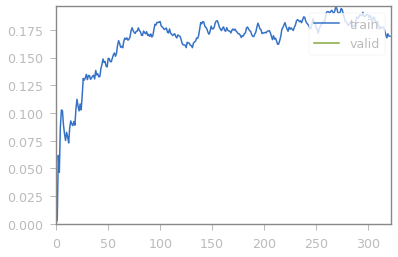

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 40 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6407


epoch,train_loss,valid_loss,accuracy,time
0,0.168436,0.096111,0.946916,01:45


Better model found at epoch 0 with accuracy value: 0.9469164609909058.


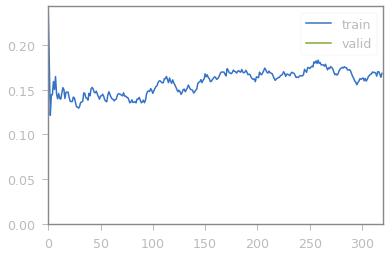

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 39 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6368


epoch,train_loss,valid_loss,accuracy,time
0,0.170819,0.111764,0.941084,01:44


Better model found at epoch 0 with accuracy value: 0.9410840272903442.


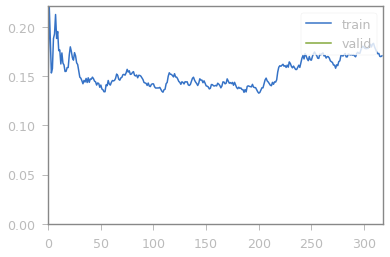

************Round:  6
TTA Accuracy:0.701470136642456
cycle 0 Error Rate is [{0: (0.6599670016499193, 29.19291853904724), 3: (2.639868006599666, 29.492950439453125), 6: (4.484775761211934, 29.852986335754395)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 37 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6331


epoch,train_loss,valid_loss,accuracy,time
0,0.162759,0.118881,0.934439,01:44


Better model found at epoch 0 with accuracy value: 0.9344391822814941.


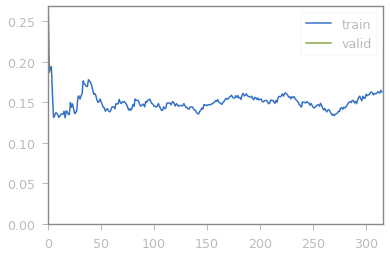

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 46 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6285


epoch,train_loss,valid_loss,accuracy,time
0,0.151145,0.108018,0.940334,01:43


Better model found at epoch 0 with accuracy value: 0.940334141254425.


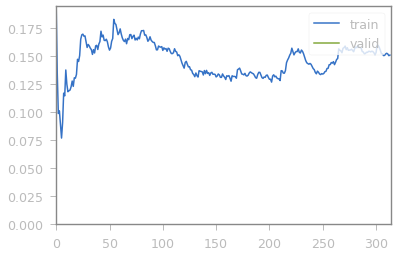

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 38 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6247


epoch,train_loss,valid_loss,accuracy,time
0,0.166267,0.083138,0.955965,01:42


Better model found at epoch 0 with accuracy value: 0.9559647440910339.


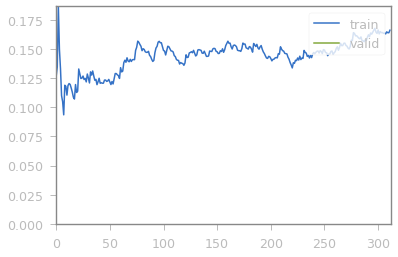

************Round:  9
TTA Accuracy:0.6963696479797363
cycle 0 Error Rate is [{0: (0.6599670016499193, 29.19291853904724), 3: (2.639868006599666, 29.492950439453125), 6: (4.484775761211934, 29.852986335754395), 9: (6.299685015749212, 30.363035202026367)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 66
Min frequency is 59
Min probability = 0.8045454545454546
Dropped 43 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
6204


epoch,train_loss,valid_loss,accuracy,time
0,0.126204,0.089270,0.951613,01:41


Better model found at epoch 0 with accuracy value: 0.9516128897666931.


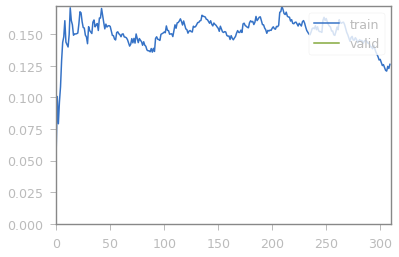

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 66
Min frequency is 58
Min probability = 0.7909090909090909
Dropped 37 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
6167


epoch,train_loss,valid_loss,accuracy,time
0,0.144117,0.085545,0.951338,01:41


Better model found at epoch 0 with accuracy value: 0.9513381719589233.


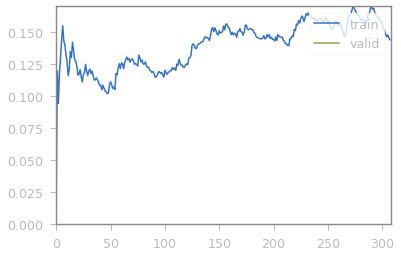

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 66
Min frequency is 57
Min probability = 0.7772727272727273
Dropped 37 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
6130


epoch,train_loss,valid_loss,accuracy,time
0,0.151753,0.087463,0.954323,01:40


Better model found at epoch 0 with accuracy value: 0.9543229937553406.


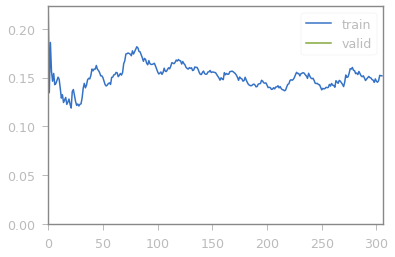

************Round:  12
TTA Accuracy:0.6981698274612427
cycle 0 Error Rate is [{0: (0.6599670016499193, 29.19291853904724), 3: (2.639868006599666, 29.492950439453125), 6: (4.484775761211934, 29.852986335754395), 9: (6.299685015749212, 30.363035202026367), 12: (8.054597270136487, 30.183017253875732)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 66
Min frequency is 56
Min probability = 0.7636363636363637
Dropped 40 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
6090


epoch,train_loss,valid_loss,accuracy,time
0,0.149952,0.088585,0.954844,01:40


Better model found at epoch 0 with accuracy value: 0.9548439979553223.


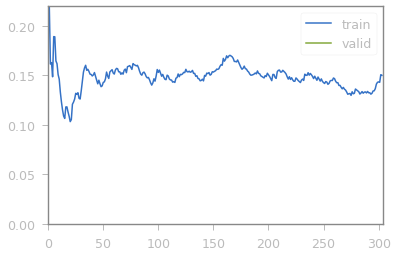

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 66
Min frequency is 56
Min probability = 0.7636363636363637
Dropped 35 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
6055


epoch,train_loss,valid_loss,accuracy,time
0,0.146786,0.094650,0.954583,01:39


Better model found at epoch 0 with accuracy value: 0.9545829892158508.


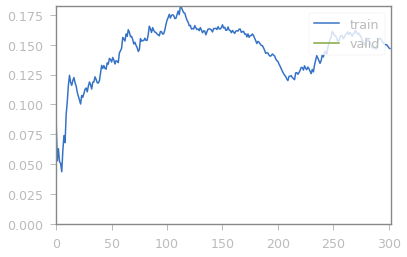

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 44 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6623


epoch,train_loss,valid_loss,accuracy,time
0,0.155993,0.079616,0.956949,01:48


Better model found at epoch 0 with accuracy value: 0.9569486379623413.


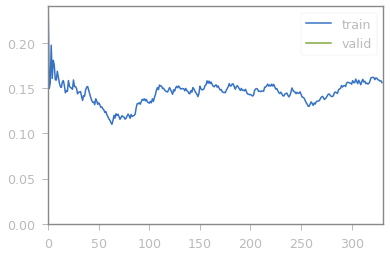

************Round:  0
TTA Accuracy:0.7011701464653015
cycle 1 Error Rate is [{0: (0.6599670016499193, 29.19291853904724), 3: (2.639868006599666, 29.492950439453125), 6: (4.484775761211934, 29.852986335754395), 9: (6.299685015749212, 30.363035202026367), 12: (8.054597270136487, 30.183017253875732), 15: (0.6599670016499193, 29.88298535346985)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 63
Min probability = 0.8462686567164179
Dropped 47 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6576


epoch,train_loss,valid_loss,accuracy,time
0,0.125597,0.084696,0.955894,01:49


Better model found at epoch 0 with accuracy value: 0.9558935165405273.


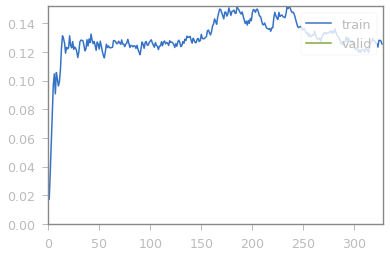

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 63
Min probability = 0.8462686567164179
Dropped 42 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6534


epoch,train_loss,valid_loss,accuracy,time
0,0.139301,0.066566,0.967075,01:47


Better model found at epoch 0 with accuracy value: 0.9670750498771667.


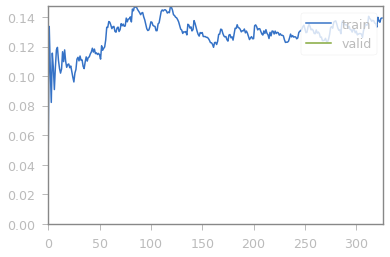

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 63
Min probability = 0.8462686567164179
Dropped 42 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6492


epoch,train_loss,valid_loss,accuracy,time
0,0.117575,0.076891,0.960709,01:46


Better model found at epoch 0 with accuracy value: 0.9607087969779968.


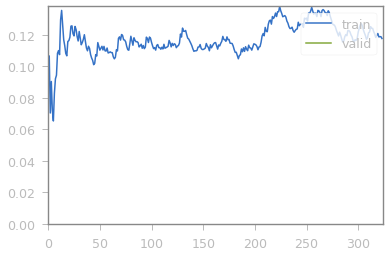

************Round:  3
TTA Accuracy:0.692169189453125
cycle 1 Error Rate is [{0: (0.6599670016499193, 29.19291853904724), 3: (2.639868006599666, 29.492950439453125), 6: (4.484775761211934, 29.852986335754395), 9: (6.299685015749212, 30.363035202026367), 12: (8.054597270136487, 30.183017253875732), 15: (0.6599670016499193, 29.88298535346985), 18: (2.624868756562171, 30.7830810546875)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 62
Min probability = 0.8328358208955224
Dropped 42 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6450


epoch,train_loss,valid_loss,accuracy,time
0,0.117311,0.079788,0.956589,01:45


Better model found at epoch 0 with accuracy value: 0.9565891623497009.


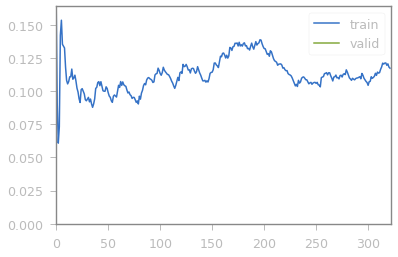

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 61
Min probability = 0.8194029850746268
Dropped 35 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6415


epoch,train_loss,valid_loss,accuracy,time
0,0.132862,0.074758,0.960249,01:45


Better model found at epoch 0 with accuracy value: 0.9602494239807129.


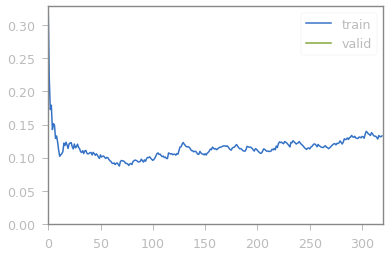

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 60
Min probability = 0.8059701492537313
Dropped 37 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6378


epoch,train_loss,valid_loss,accuracy,time
0,0.119767,0.054460,0.970980,01:44


Better model found at epoch 0 with accuracy value: 0.9709804058074951.


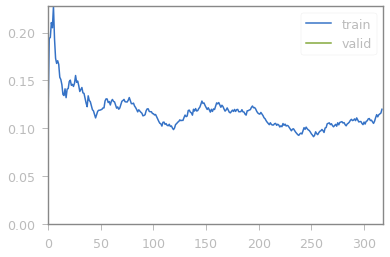

************Round:  6
TTA Accuracy:0.6888688802719116
cycle 1 Error Rate is [{0: (0.6599670016499193, 29.19291853904724), 3: (2.639868006599666, 29.492950439453125), 6: (4.484775761211934, 29.852986335754395), 9: (6.299685015749212, 30.363035202026367), 12: (8.054597270136487, 30.183017253875732), 15: (0.6599670016499193, 29.88298535346985), 18: (2.624868756562171, 30.7830810546875), 21: (4.334783260836961, 31.113111972808838)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 60
Min probability = 0.8059701492537313
Dropped 43 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6335


epoch,train_loss,valid_loss,accuracy,time
0,0.121488,0.072191,0.960537,01:44


Better model found at epoch 0 with accuracy value: 0.9605367183685303.


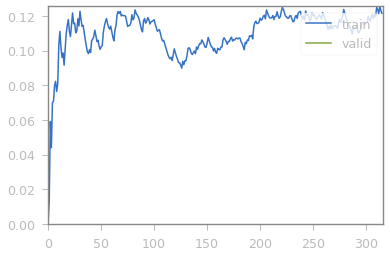

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 38 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6297


epoch,train_loss,valid_loss,accuracy,time
0,0.117278,0.066197,0.965846,01:43


Better model found at epoch 0 with accuracy value: 0.9658458828926086.


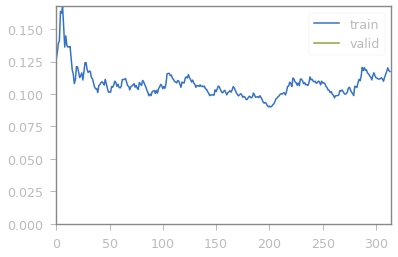

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 58
Min probability = 0.7791044776119402
Dropped 35 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6262


epoch,train_loss,valid_loss,accuracy,time
0,0.099023,0.065274,0.964058,01:43


Better model found at epoch 0 with accuracy value: 0.9640575051307678.


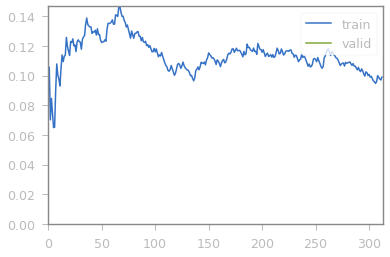

************Round:  9
TTA Accuracy:0.6852685213088989
cycle 1 Error Rate is [{0: (0.6599670016499193, 29.19291853904724), 3: (2.639868006599666, 29.492950439453125), 6: (4.484775761211934, 29.852986335754395), 9: (6.299685015749212, 30.363035202026367), 12: (8.054597270136487, 30.183017253875732), 15: (0.6599670016499193, 29.88298535346985), 18: (2.624868756562171, 30.7830810546875), 21: (4.334783260836961, 31.113111972808838), 24: (6.074696265186741, 31.473147869110107)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 38 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
6224


epoch,train_loss,valid_loss,accuracy,time
0,0.103199,0.065088,0.964630,01:42


Better model found at epoch 0 with accuracy value: 0.9646302461624146.


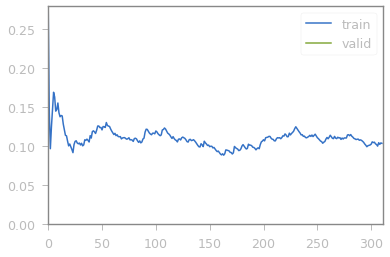

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 38 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
6186


epoch,train_loss,valid_loss,accuracy,time
0,0.115422,0.057456,0.970897,01:41


Better model found at epoch 0 with accuracy value: 0.9708973169326782.


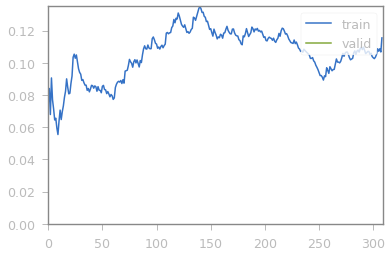

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 55
Min probability = 0.7388059701492538
Dropped 35 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
6151


epoch,train_loss,valid_loss,accuracy,time
0,0.102721,0.057589,0.967480,01:41


Better model found at epoch 0 with accuracy value: 0.9674796462059021.


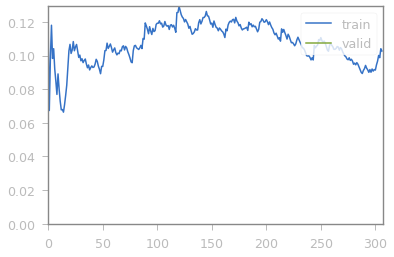

************Round:  12
TTA Accuracy:0.6783678531646729
cycle 1 Error Rate is [{0: (0.6599670016499193, 29.19291853904724), 3: (2.639868006599666, 29.492950439453125), 6: (4.484775761211934, 29.852986335754395), 9: (6.299685015749212, 30.363035202026367), 12: (8.054597270136487, 30.183017253875732), 15: (0.6599670016499193, 29.88298535346985), 18: (2.624868756562171, 30.7830810546875), 21: (4.334783260836961, 31.113111972808838), 24: (6.074696265186741, 31.473147869110107), 27: (7.739613019349035, 32.163214683532715)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 32 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
6119


epoch,train_loss,valid_loss,accuracy,time
0,0.111122,0.062247,0.967294,01:40


Better model found at epoch 0 with accuracy value: 0.9672935605049133.


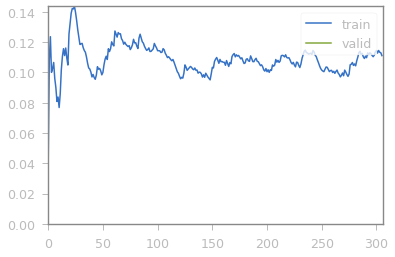

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 66
Min frequency is 53
Min probability = 0.7227272727272727
Dropped 37 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
6082


epoch,train_loss,valid_loss,accuracy,time
0,0.117537,0.058757,0.973684,01:40


Better model found at epoch 0 with accuracy value: 0.9736841917037964.


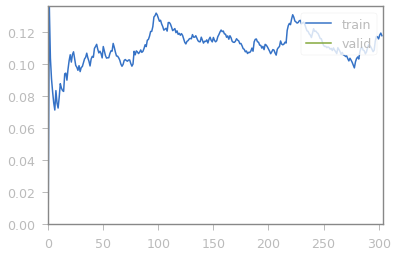

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 45 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6622


epoch,train_loss,valid_loss,accuracy,time
0,0.110900,0.063060,0.966767,01:48


Better model found at epoch 0 with accuracy value: 0.9667673707008362.


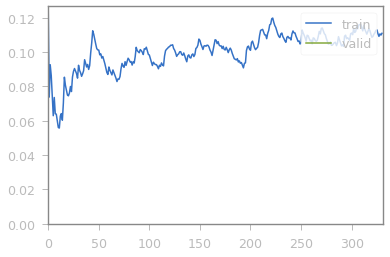

************Round:  0
TTA Accuracy:0.6846684813499451
cycle 2 Error Rate is [{0: (0.6599670016499193, 29.19291853904724), 3: (2.639868006599666, 29.492950439453125), 6: (4.484775761211934, 29.852986335754395), 9: (6.299685015749212, 30.363035202026367), 12: (8.054597270136487, 30.183017253875732), 15: (0.6599670016499193, 29.88298535346985), 18: (2.624868756562171, 30.7830810546875), 21: (4.334783260836961, 31.113111972808838), 24: (6.074696265186741, 31.473147869110107), 27: (7.739613019349035, 32.163214683532715), 30: (0.6749662516874144, 31.533151865005493)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 63
Min probability = 0.8462686567164179
Dropped 41 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6581


epoch,train_loss,valid_loss,accuracy,time
0,0.114276,0.042975,0.976444,01:47


Better model found at epoch 0 with accuracy value: 0.9764437675476074.


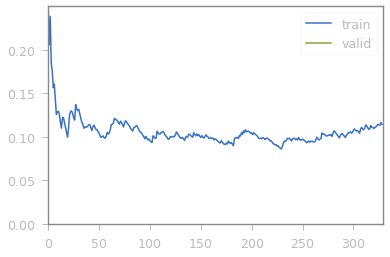

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 63
Min probability = 0.8462686567164179
Dropped 42 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6539


epoch,train_loss,valid_loss,accuracy,time
0,0.086115,0.050114,0.974751,01:47


Better model found at epoch 0 with accuracy value: 0.974751353263855.


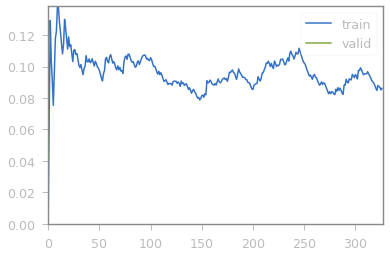

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 62
Min probability = 0.8328358208955224
Dropped 40 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6499


epoch,train_loss,valid_loss,accuracy,time
0,0.063282,0.055163,0.969977,01:46


Better model found at epoch 0 with accuracy value: 0.9699769020080566.


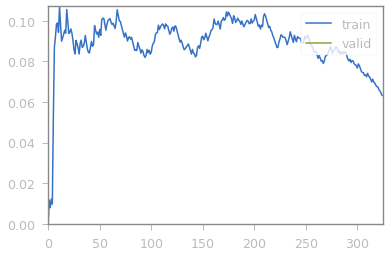

************Round:  3
TTA Accuracy:0.6861686110496521
cycle 2 Error Rate is [{0: (0.6599670016499193, 29.19291853904724), 3: (2.639868006599666, 29.492950439453125), 6: (4.484775761211934, 29.852986335754395), 9: (6.299685015749212, 30.363035202026367), 12: (8.054597270136487, 30.183017253875732), 15: (0.6599670016499193, 29.88298535346985), 18: (2.624868756562171, 30.7830810546875), 21: (4.334783260836961, 31.113111972808838), 24: (6.074696265186741, 31.473147869110107), 27: (7.739613019349035, 32.163214683532715), 30: (0.6749662516874144, 31.533151865005493), 33: (2.5198740062996827, 31.38313889503479)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 62
Min probability = 0.8328358208955224
Dropped 40 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6459


epoch,train_loss,valid_loss,accuracy,time
0,0.094100,0.052716,0.971340,01:46


Better model found at epoch 0 with accuracy value: 0.9713400602340698.


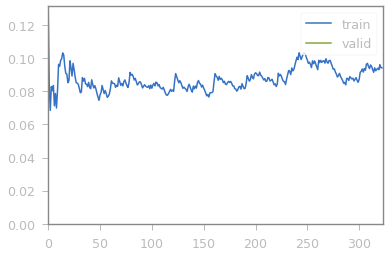

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 61
Min probability = 0.8194029850746268
Dropped 38 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6421


epoch,train_loss,valid_loss,accuracy,time
0,0.094009,0.054726,0.969626,01:45


Better model found at epoch 0 with accuracy value: 0.9696261882781982.


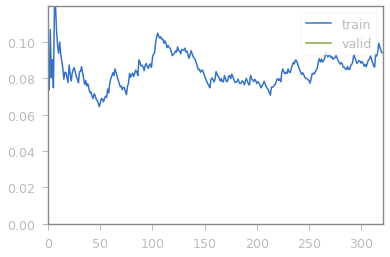

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 42 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6379


epoch,train_loss,valid_loss,accuracy,time
0,0.092779,0.056769,0.970196,01:44


Better model found at epoch 0 with accuracy value: 0.9701960682868958.


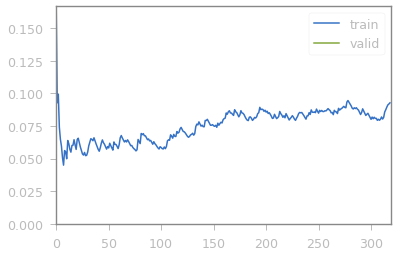

************Round:  6
TTA Accuracy:0.6810681223869324
cycle 2 Error Rate is [{0: (0.6599670016499193, 29.19291853904724), 3: (2.639868006599666, 29.492950439453125), 6: (4.484775761211934, 29.852986335754395), 9: (6.299685015749212, 30.363035202026367), 12: (8.054597270136487, 30.183017253875732), 15: (0.6599670016499193, 29.88298535346985), 18: (2.624868756562171, 30.7830810546875), 21: (4.334783260836961, 31.113111972808838), 24: (6.074696265186741, 31.473147869110107), 27: (7.739613019349035, 32.163214683532715), 30: (0.6749662516874144, 31.533151865005493), 33: (2.5198740062996827, 31.38313889503479), 36: (4.319784010799454, 31.893187761306763)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 58
Min probability = 0.7791044776119402
Dropped 41 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6338


epoch,train_loss,valid_loss,accuracy,time
0,0.077605,0.051493,0.973954,01:44


Better model found at epoch 0 with accuracy value: 0.9739542007446289.


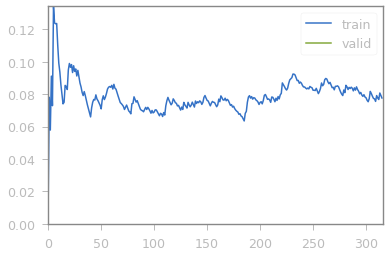

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 58
Min probability = 0.7791044776119402
Dropped 36 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6302


epoch,train_loss,valid_loss,accuracy,time
0,0.080711,0.039931,0.978571,01:43


Better model found at epoch 0 with accuracy value: 0.9785714149475098.


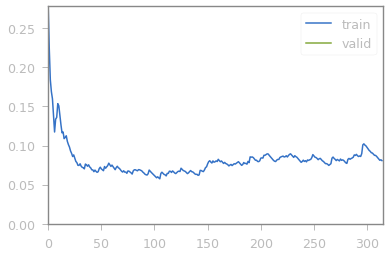

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 58
Min probability = 0.7791044776119402
Dropped 43 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6259


epoch,train_loss,valid_loss,accuracy,time
0,0.088269,0.035908,0.982414,01:42


Better model found at epoch 0 with accuracy value: 0.9824140667915344.


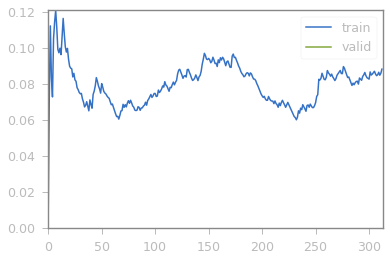

************Round:  9
TTA Accuracy:0.6816681623458862
cycle 2 Error Rate is [{0: (0.6599670016499193, 29.19291853904724), 3: (2.639868006599666, 29.492950439453125), 6: (4.484775761211934, 29.852986335754395), 9: (6.299685015749212, 30.363035202026367), 12: (8.054597270136487, 30.183017253875732), 15: (0.6599670016499193, 29.88298535346985), 18: (2.624868756562171, 30.7830810546875), 21: (4.334783260836961, 31.113111972808838), 24: (6.074696265186741, 31.473147869110107), 27: (7.739613019349035, 32.163214683532715), 30: (0.6749662516874144, 31.533151865005493), 33: (2.5198740062996827, 31.38313889503479), 36: (4.319784010799454, 31.893187761306763), 39: (6.119694015299237, 31.833183765411377)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 38 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
6221


epoch,train_loss,valid_loss,accuracy,time
0,0.089948,0.049591,0.973473,01:42


Better model found at epoch 0 with accuracy value: 0.9734726548194885.


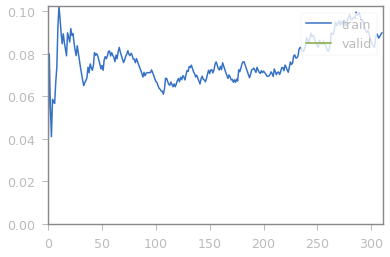

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 66
Min frequency is 57
Min probability = 0.7772727272727273
Dropped 39 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
6182


epoch,train_loss,valid_loss,accuracy,time
0,0.082343,0.042199,0.977346,01:41


Better model found at epoch 0 with accuracy value: 0.9773463010787964.


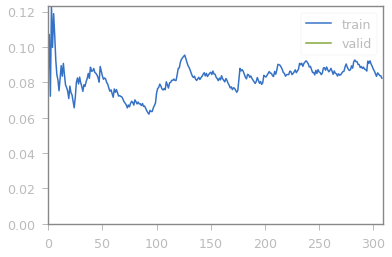

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 66
Min frequency is 56
Min probability = 0.7636363636363637
Dropped 36 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
6146


epoch,train_loss,valid_loss,accuracy,time
0,0.087751,0.041954,0.978031,01:41


Better model found at epoch 0 with accuracy value: 0.9780309200286865.


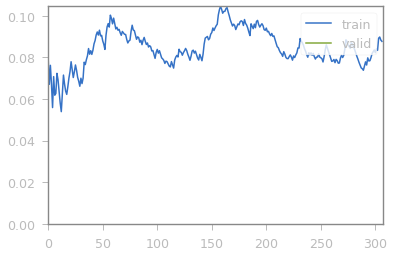

************Round:  12
TTA Accuracy:0.6807680726051331
cycle 2 Error Rate is [{0: (0.6599670016499193, 29.19291853904724), 3: (2.639868006599666, 29.492950439453125), 6: (4.484775761211934, 29.852986335754395), 9: (6.299685015749212, 30.363035202026367), 12: (8.054597270136487, 30.183017253875732), 15: (0.6599670016499193, 29.88298535346985), 18: (2.624868756562171, 30.7830810546875), 21: (4.334783260836961, 31.113111972808838), 24: (6.074696265186741, 31.473147869110107), 27: (7.739613019349035, 32.163214683532715), 30: (0.6749662516874144, 31.533151865005493), 33: (2.5198740062996827, 31.38313889503479), 36: (4.319784010799454, 31.893187761306763), 39: (6.119694015299237, 31.833183765411377), 42: (7.814609269536521, 31.923192739486694)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 65
Min frequency is 56
Min probability = 0.7753846153846154
Dropped 35 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
6111


epoch,train_loss,valid_loss,accuracy,time
0,0.089235,0.041250,0.977905,01:40


Better model found at epoch 0 with accuracy value: 0.9779050946235657.


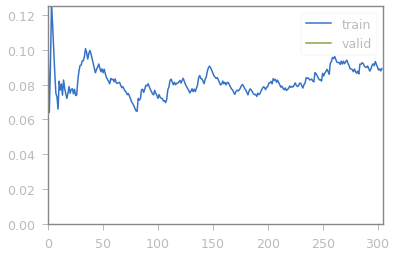

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 65
Min frequency is 55
Min probability = 0.7615384615384615
Dropped 41 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
6070


epoch,train_loss,valid_loss,accuracy,time
0,0.077294,0.048056,0.976112,01:39


Better model found at epoch 0 with accuracy value: 0.9761120080947876.


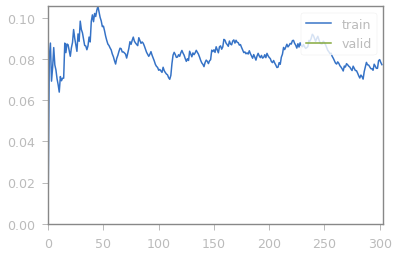

In [41]:
delta_max = 0.50
accs = []
deltas = []
err = {}
for c in range(cleaning_cycles):
    for n in range(n_training_series):
        
        delta =  delta_max * math.sin( math.pi * float(n+1)/(n_training_series) )
        loss_func = losses.DampedGCELossFlat(num_classes=num_classes,q=0.5, delta = delta, reduction='mean')
        k_samples = 50
        print(f'+++++ Training serie: inverse pyramid {n} ++++++++')
        epochs_per_serie = min_epochs + n * delta_epochs_per_serie
        lr = min_lr * kappa_lr * (n_training_series - n)
        data_per_serie[n+1] = data_definition(data_per_serie[n],imgs,batch_tfms,model,best_pth,k_samples=k_samples, 
                                              min_prob = min_prob, max_prob=max_prob, largest = largest)
        print("************Round: ",n)
        print("************data per serie:******************")
        print("************length of data per serie:******************")
        print(len(data_per_serie[n+1]))
        
        databunch = ( ImageDataLoaders.from_df(data_per_serie[n+1], valid_pct = 0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

        learn =(learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func,
                            cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
        learn.unfreeze() 
        learn.load(best_pth)
        learn.fit_one_cycle(epochs_per_serie, lr_max=slice(1e-6, 5e-5))
        if n%3== 0:
            log_preds, y = learn.tta(dl=data_test)
            print("************Round: ",n)
            tta_acc = accuracy(log_preds, y)
            print(f'TTA Accuracy:{tta_acc}')
            accs.append(tta_acc)
            deltas.append(delta)
            err[c*n_training_series + n] = ( 100.0 *float(1.0 - len(data_per_serie[n+1])/len(data_per_serie[0])) ,  100.0 * (1.0 - float(tta_acc)))
            print(f'cycle {c} Error Rate is [{err}]')
            PATH='models/'+damp_2_features+'_'+str(c)+"_"+str(n)+".p"
            torch.save(model.state_dict(), PATH)
            csv = data_per_serie[n+1].to_csv('CSVz/'+damp_2_csvs+'_'+str(c)+"_"+str(n)+".csv", index = False)         

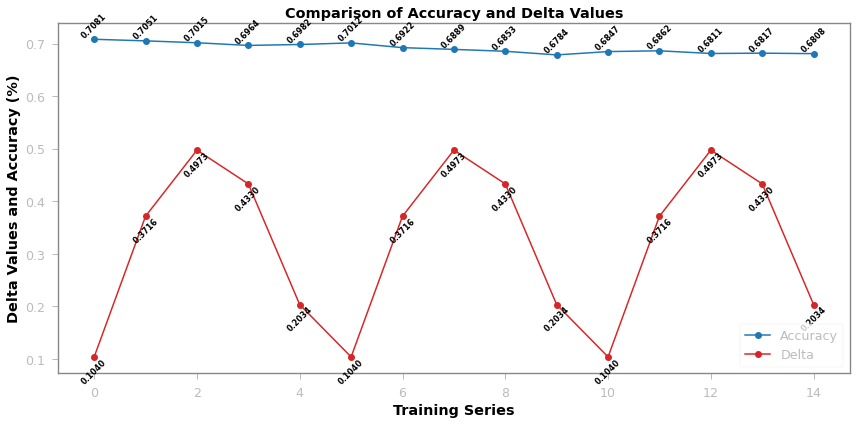

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(accs, label='Accuracy', color='tab:blue', marker='o')
plt.plot(deltas, label='Delta', color='tab:red', marker='o')

# Annotating each point with its value in black and with bold labels
for i, (acc, delta) in enumerate(zip(accs, deltas)):
    plt.text(i, acc, f"{acc:.4f}", ha='center', va='bottom', fontsize=8, rotation=45, color='black', fontweight='bold')
    plt.text(i, delta, f"{delta:.4f}", ha='center', va='top', fontsize=8, rotation=45, color='black', fontweight='bold')

plt.title('Comparison of Accuracy and Delta Values', fontweight='bold', color = 'Black')
plt.xlabel('Training Series', fontweight='bold', color = 'black')
plt.ylabel('Delta Values and Accuracy (%)', fontweight='bold', color = 'Black')
plt.legend()
plt.grid(False)
plt.tight_layout()  # Adjust layout to prevent clipping of annotations
plt.show()
